## ALL FUNCTION FOR LAB

In [ ]:
import os
import cv2
import json
import math
import random
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from pylab import imread
from scipy import ndimage
from skimage import measure
import matplotlib.pyplot as pl
from google.colab import drive
from skimage.morphology import disk
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.transform import rescale, resize
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
def ConnectToDataFolder(FolderPath):
  print("=" * 80, "- Begin: ConnectToDataFolder")

  if (os.path.isdir(FolderPath)):
    os.chdir(FolderPath)
    print("List of Data in the Folder :")
    display(os.listdir())
  else:
    print(f"{FolderPath} is not correct, please check the folder again")

  print("=" * 80, "- Finish: ConnectToDataFolder")

In [ ]:
def GetSubFiles(dir, ExtensionList = []):
    print("=" * 80, "- Begin: GetSubFiles")

    "Get a list of immediate subfiles"
    all_names = next(os.walk(dir))[2]
    subfile_names = []
    if(len(ExtensionList) > 0):
      for filename in all_names:
        fname, fextension = os.path.splitext(filename)
        if any(ext in fextension for ext in ExtensionList):
          subfile_names.append(dir + "/" + filename)
    else:
      subfile_names = [dir + "/" + x for x in all_names]

    print(f"There are {len(subfile_names)} files are found")
    subfile_names.sort()
    print("Here is some samples :")
    [print(x) for x in subfile_names[0: min(len(subfile_names), 5)]]

    print("=" * 20, "- End: GetSubFiles")
    return subfile_names

In [ ]:
def convert_float32_to_uint8(image):
    if image.dtype == np.float32:
        image_uint8 = (image * 255).astype(np.uint8)
    else:
        image_uint8 = image

    return image

In [ ]:
def ShowImage(ImageList, nRows=1, nCols=2, ImageTitleList=[]):
    gs = gridspec.GridSpec(nRows, nCols)
    plt.figure(figsize=(20, 20))
    for i in range(len(ImageList)):
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        plt.subplot(nRows, nCols, i + 1)

        image = ImageList[i].copy()
        convert_float32_to_uint8(image)
        if len(image.shape) < 3:
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)

        if len(ImageTitleList) > 0:
            plt.title("Image " + str(ImageTitleList[i]))
        else:
            plt.title("Image " + str(i))

        plt.axis('off')

    plt.show()

In [ ]:
def ShowRandomImage(DatasetFiles, nRows = 1, nCols = 5, seedNo = 10):
  print("=" * 20, "- Begin: ShowRandomImage")

  nFile = nRows * nCols

  random.seed(seedNo)
  FileNameList = random.sample(DatasetFiles, nFile)
  ImageList = []
  for filepath in FileNameList:
    image_RGB = imread(filepath)
    ImageList.append(image_RGB)

  ShowImage(ImageList, nRows, nCols, FileNameList)

  print("=" * 20, "- Finish: ShowRandomImage")
  return FileNameList, ImageList

In [ ]:
def ResizeImage(image, wresize = 0, hresize = 0):
  OrigWidth, OrigHeight = float(image.shape[1]), float(image.shape[0])

  convert_float32_to_uint8(image)

  if((wresize == 0) & (hresize == 0)):
      return image
  if(wresize == 0):
      wresize = int((OrigWidth * hresize)/OrigHeight)
  if(hresize == 0):
      hresize = int((OrigHeight * wresize)/OrigWidth)
  resize_image = cv2.resize(image, (wresize, hresize), interpolation = cv2.INTER_NEAREST)
  return resize_image

In [ ]:
def ConvertColorSpaces(image, ColorSpace = "GRAY", display = 1):
  ImageTitleList = ["RGB", ColorSpace]

  convert_float32_to_uint8(image)

  if(ColorSpace.upper() == "HSV"):
    image_convert = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ChannelList = ["Chrominance Hue" , "Chrominance Saturation", "Luminance Value"]
  elif(ColorSpace.upper() == "YCRCB"):
    image_convert = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    ChannelList = ["Chrominance Red" , "Chrominance Blue", "Luminance Y"]
  elif(ColorSpace.upper() == "LAB"):
    image_convert = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    ChannelList = ["Chrominance a(Green To Red)" , "Chrominance b(Blue To Yellow)", "Luminance L"]
  else:
    image_convert = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  if(display):
    if(len(image_convert.shape) == 3):
      ShowImage([image, image_convert, image_convert[:,:,0], image_convert[:,:,1], image_convert[:,:,2]], 1, 5,
                ImageTitleList + ChannelList)
    else:
      ShowImage([image, image_convert], 1, 5, ImageTitleList)

  return image_convert

In [ ]:
def ShowHistogram(image, Title = "Color Histogram", ChannelList = ["Channel 1", "Channel 2", "Channel 3"]):
  fig, ax = plt.subplots(figsize=(20, 10))

  convert_float32_to_uint8(image)

  if(len(image.shape) == 3):
    color = ('r', 'g', 'b')
    for channel,col in enumerate(color):
        histr = cv2.calcHist([image],[channel],None,[256],[0,256])
        ax.plot(histr,color = col, label = ChannelList[channel])

    plt.title(Title)
    plt.legend()
  else:
    histr = cv2.calcHist([image],[0],None,[256],[0,256])
    plt.plot(histr,color = "gray", label = "Gray")
    plt.title("Gray Histogram")
    plt.legend()

  # Set axis ranges; by default this will put major ticks every 25.
  ax.set_xlim(0, 255)

  # Change major ticks to show every 20.
  ax.xaxis.set_major_locator(MultipleLocator(20))

  # Change minor ticks to show every 5. (20/4 = 5)
  ax.xaxis.set_minor_locator(AutoMinorLocator(4))

  # Turn grid on for both major and minor ticks and style minor slightly
  # differently.
  ax.grid(which='major', color='#CCCCCC', linestyle='--')
  ax.grid(which='minor', color='#CCCCCC', linestyle=':')
  plt.show()

In [ ]:
def SegmentByThresh(image, channel, segment_range = [], display = 1):
  if(len(segment_range) == 0):
    convert_float32_to_uint8(image)
    thresh, image_mask = cv2.threshold(channel,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    print(f"Otsu Threshold : {thresh}")
  else:
    image_mask = ((channel > segment_range[0]) & (channel < segment_range[1]))

  image_segment = cv2.bitwise_and(image, image, mask = image_mask.astype(np.uint8))

  ImageTitleList = ["Color Image", "Segmented Channel", "Segmented Mask", "Segmented Color Image"]
  if(display):
    ShowImage([image, channel, image_mask, image_segment], 1, 5, ImageTitleList)

  image_mask = image_mask.astype(bool)
  return image_mask

In [ ]:
def GetLargestBinaryArea(image, image_mask, display = 1):
  labels_mask = measure.label(image_mask)
  regions = measure.regionprops(labels_mask)
  regions.sort(key=lambda x: x.area, reverse=True)
  if len(regions) > 1:
      for rg in regions[1:]:
          labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
  labels_mask[labels_mask!=0] = 1
  image_mask = labels_mask

  image_segment = cv2.bitwise_and(image, image, mask = image_mask.astype(np.uint8))
  ImageTitleList = ["Color Image", "Segmented Mask", "Segmented Color Image"]

  if(display):
    ShowImage([image, image_mask, image_segment], 1, 5, ImageTitleList)

  return image_mask

In [ ]:

def LabelObjectByMask(image_input, image_mask, type = "BBox", color = (255,0,0)):
    image_output = image_input.copy()

    Marker_Size = int(AnImage.shape[0] * 0.1)
    Marker_Thick = int(AnImage.shape[0] * 0.01)
    BBoxThick = int(AnImage.shape[0] * 0.01)
    ContourThick = int(AnImage.shape[0] * 0.01)

    label_img = label(image_mask)
    regions = regionprops(label_img)
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        left_top = (minc, minr)
        right_bottom = (maxc, maxr)
        at_row, at_col = props.centroid

        if(type == "BBox"):
          cv2.rectangle(image_output,left_top, right_bottom, color ,BBoxThick)

        if(type == "Boundary"):
          contours, heirarchy = cv2.findContours(image_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
          cv2.drawContours(image_output, contours, -1, color, ContourThick)
          cv2.drawMarker(image_output, (int(at_col), int(at_row)),color, markerType=cv2.MARKER_STAR,
                           markerSize= Marker_Size, thickness= Marker_Thick, line_type=cv2.LINE_AA)

        if(type == "Fill"):
          color_array = np.full((np.sum(image_mask > 0), 4), (*color, 255), dtype=np.uint8)
          image_output[image_mask > 0] = color_array

    return image_output

In [ ]:
def IntensityTransformation(image, gamma = 0.3, display = 1):
  image_gamma_corrected = np.array(255*(image / 255) ** gamma, dtype = 'uint8')
  ShowImage([image, image_gamma_corrected], 1, 5, ["Original Image", f"Gamma = {gamma}"])
  if(display):
    GammaImageList = []
    TitleList = []

    for g in [0.3, 0.5, 0.9,  1.2, 2.2]:
      # Apply gamma correction.
      gamma_corrected = np.array(255*(image / 255) ** g, dtype = 'uint8')
      GammaImageList.append(gamma_corrected)
      TitleList.append(f"Gamma = {g}")

    ShowImage(GammaImageList, 1, 5, TitleList)
  return image_gamma_corrected

In [ ]:
# Morphology
def Morphology(image, image_mask, morType = "erosion", size = 3, display = 1):
  image_mask = image_mask.astype(np.uint8)
  kernel = disk(abs(size))

  if(morType == "erosion"):
    result = erosion(image_mask, kernel)
  if(morType == "dilation"):
    result = dilation(image_mask, kernel)
  if(morType == "opening"):
    result = opening(image_mask, kernel)
  if(morType == "closing"):
    result = closing(image_mask, kernel)
  if(morType == "gradient"):
    result = cv2.morphologyEx(image_mask, cv2.MORPH_GRADIENT, kernel)
  if(morType == "tophat"):
    result = white_tophat(image_mask, kernel)
  if(morType == "blackhat"):
    result = black_tophat(image_mask, kernel)
  if(morType == "fillhole"):
    result = ndimage.binary_fill_holes(image_mask).astype(int)
  if(morType == "skeleton"):
    result = skeletonize(image_mask == 1)
  if(morType == "convexhull"):
    result = convex_hull_image(image_mask == 1)

  if(display):
    image_mask_color = cv2.bitwise_and(image, image, mask = result.astype(np.uint8))

    im_erosion = erosion(image_mask, kernel)
    im_dilation = dilation(image_mask, kernel)
    im_opening = opening(image_mask, kernel)
    im_closing = closing(image_mask, kernel)
    im_gradient = cv2.morphologyEx(image_mask, cv2.MORPH_GRADIENT, kernel)
    im_tophat = white_tophat(image_mask, kernel)
    im_blackhat = black_tophat(image_mask, kernel)
    im_fillhole = ndimage.binary_fill_holes(image_mask).astype(int)
    im_skeleton = skeletonize(image_mask == 1)
    im_convexhull = convex_hull_image(image_mask == 1)

    ShowImage([image, result, image_mask_color], 1, 5, ImageTitleList= ["Color Image", "Mask", "Segment By Mask"])
    ShowImage([im_erosion, im_dilation, im_opening, im_closing, im_gradient], 1, 5,
              ImageTitleList= ["Erosion", "Dilation", "Opening", "Closing", "Gradient"])
    ShowImage([im_tophat, im_blackhat, im_fillhole, im_skeleton, im_convexhull], 1, 5,
              ImageTitleList= ["Tophat", "BlackHat", "FillHole", "Skeleton", "Convexhull"])

  result = result.astype(bool)
  return result

In [ ]:

def ConcatImage(ImageList, CombineType="h", display=1):
    sample_shape = ImageList[0].shape

    resized_images = [cv2.resize(image[:, :, :3], (sample_shape[1], sample_shape[0])) for image in ImageList]

    if CombineType == "h":
        result = np.concatenate(resized_images, axis=1)
    else:
        result = np.concatenate(resized_images, axis=0)

    if display:
        # Hiển thị hình ảnh
        plt.imshow(result)
        plt.axis('off')
        plt.show()

    result = np.uint8(result)
    return result

In [ ]:
def GenerateOutput(image, image_mask, FilePath = "", SaveFolderPath = ""):
  image_output_rgbmask = cv2.merge([image_mask*255, image_mask*255, image_mask*255])
  image_output_fill = LabelObjectByMask(image, image_mask, type = "Fill", color = (255,0,0))
  image_output_bbox = LabelObjectByMask(image, image_mask, type = "BBox", color = (255,0,0))
  image_output_boundary = LabelObjectByMask(image, image_mask, type = "Boundary", color = (255,0,0))

  DemoImage1 = ConcatImage([image_output_rgbmask, image_output_fill], display= 0)
  DemoImage2 = ConcatImage([image_output_bbox, image_output_boundary], display= 0)
  DemoImage = ConcatImage([DemoImage1, DemoImage2], CombineType = "v", display= 0)

  if(len(FolderPath) > 0):
    filename = Path(FilePath).stem
    print(f"Already Save Results to Folder {SaveFolderPath}")

    print(f'{SaveFolderPath}/{filename}_rgbmask.jpg')
    cv2.imwrite(f'{SaveFolderPath}/{filename}_mask.jpg', image_output_rgbmask)

    print(f'{SaveFolderPath}/{filename}_demo.jpg')
    cv2.imwrite(f'{SaveFolderPath}/{filename}_demo.jpg', cv2.cvtColor(DemoImage, cv2.COLOR_RGB2BGR))

  return image_output_rgbmask, image_output_fill, image_output_bbox, image_output_boundary, DemoImage


In [ ]:
def doOrangeMaskSegment(AnImage, image_mask, display = 1):
  MaskList = []
  MaskList.append(image_mask)
  image_mask_adjust = Morphology(AnImage, image_mask, morType = "fillhole", size = 8, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = Morphology(AnImage, image_mask_adjust, morType = "erosion", size = 8, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = GetLargestBinaryArea(AnImage, image_mask_adjust, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = Morphology(AnImage, image_mask_adjust, morType = "dilation", size = 10, display = 0)
  MaskList.append(image_mask_adjust)

  if(display):
    ShowImage(MaskList, 1, 5)

  return image_mask_adjust

In [ ]:
def doOrangeMaskSegment2(AnImage, image_mask, display = 1):
  MaskList = []
  MaskList.append(image_mask)
  image_mask_adjust = Morphology(AnImage, image_mask, morType = "fillhole", size = 8, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = Morphology(AnImage, image_mask_adjust, morType = "erosion", size = 50, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = GetLargestBinaryArea(AnImage, image_mask_adjust, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = Morphology(AnImage, image_mask_adjust, morType = "dilation", size = 50, display = 0)
  MaskList.append(image_mask_adjust)

  if(display):
    ShowImage(MaskList, 1, 5)

  return image_mask_adjust

In [ ]:
def doOrangeMaskSegment3(AnImage, image_mask, display = 1):
  MaskList = []
  MaskList.append(image_mask)
  image_mask_adjust = Morphology(AnImage, image_mask, morType = "erosion", size = 3, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = Morphology(AnImage, image_mask_adjust, morType = "fillhole", size = 1, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = GetLargestBinaryArea(AnImage, image_mask_adjust, display = 0)
  MaskList.append(image_mask_adjust)
  image_mask_adjust = Morphology(AnImage, image_mask_adjust, morType = "dilation", size = 3, display = 0)
  MaskList.append(image_mask_adjust)

  if(display):
    ShowImage(MaskList, 1, 5)

  return image_mask_adjust

In [ ]:
def GetContourCenter(image, image_mask, display = 1):
  image_label = label(GetLargestBinaryArea(image, image_mask, display = 0))
  regions = regionprops(image_label, intensity_image= image_mask)
  props = regions[0]
  (center_y, center_x) =  props.centroid
  CenterPoints = [int(center_x), int(center_y)]

  contours, hierarchy = cv2.findContours(image_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  ContourPoints = np.squeeze(contours[0], axis=1)

  if(display):
    print(f"Center Point at X = {CenterPoints[0]} and Y = {CenterPoints[1]}")
    print(f"Contours Points are \n {ContourPoints}")

    image_demo = image.copy()
    cv2.drawMarker(image_demo, (CenterPoints[0], CenterPoints[1]),(255,255,0),
                   markerType=cv2.MARKER_STAR, markerSize=25, thickness=2, line_type=cv2.LINE_AA)

    count = 0
    for x_idx, y_idx in ContourPoints:
      count = count + 1
      if(count % 15 == 0):
        cv2.drawMarker(image_demo, (x_idx, y_idx),(255,0,0),
                    markerType=cv2.MARKER_STAR, markerSize=10, thickness=2, line_type=cv2.LINE_AA)

    ShowImage([image_mask, image_demo], 1, 5)
  return CenterPoints, ContourPoints

In [ ]:
def GetMinorMajorLength(image, image_mask, display = 1):
  image_label = label(GetLargestBinaryArea(image, image_mask, display = 0))
  regions = regionprops(image_label, intensity_image= image_mask)
  props = regions[0]

  minorLength = props.minor_axis_length
  majorLength = props.major_axis_length
  orientation = props.orientation
  minr, minc, maxr, maxc = props.bbox
  bbox = [minr, minc, maxr, maxc]

  if(display):
    print(f"Minor Length = {minorLength} and Major Length = {majorLength} and Orientation = {orientation}")
    print(f"Bounding Box minr, minc, maxr, maxc are : {bbox}")
    y0, x0 = props.centroid
    x1 = int(x0 + math.cos(orientation) * 0.5 * minorLength)
    y1 = int(y0 - math.sin(orientation) * 0.5 * minorLength)
    x2 = int(x0 - math.sin(orientation) * 0.5 * majorLength)
    y2 = int(y0 - math.cos(orientation) * 0.5 * majorLength)
    x0 = int(x0)
    y0 = int(y0)

    image_demo = image.copy()
    cv2.line(image_demo, (x0, y0), (x1, y1), (0, 255, 0), thickness=3)
    cv2.line(image_demo, (x0, y0), (x2, y2), (0, 255, 0), thickness=3)

    ShowImage([image_mask, image_demo], 1, 5)
  return minorLength, majorLength, orientation, bbox

In [ ]:
def GetAreaPerimeterSolidity(image, image_mask, display = 1):
  image_label = label(GetLargestBinaryArea(image, image_mask, display = 0))
  regions = regionprops(image_label, intensity_image= image_mask)
  props = regions[0]

  Area = int(props.area)
  Perimeter = int(props.perimeter)
  # Ratio of pixels in the region to pixels of the convex hull image.
  Solidity = props.solidity
  Roundness = (4 * math.pi * Area) / (Perimeter * Perimeter)

  if(display):
    print(f"Area : {Area}, Perimeter : {Perimeter}, Solidity : {Solidity}, Roundness : {Roundness}")

  return Area, Perimeter, Solidity, Roundness

In [ ]:
def GetMinMaxMeanQuantileIntensity(image, image_mask, image_value, display = 1):
  image_label = label(GetLargestBinaryArea(image, image_mask, display = 0))
  regions = regionprops(image_label, intensity_image= image_value)
  props = regions[0]

  image_value[image_mask != 1] = 0
  vectorized = image_value.reshape(-1)
  vectorized = np.float32(vectorized)
  vectorized = vectorized[vectorized != 0]

  IntensityMax = np.max(vectorized)
  IntensityMean = np.mean(vectorized)
  IntensityMin = np.min(vectorized)
  IntensityQ1 = np.quantile(vectorized, 0.25)
  IntensityQ2 = np.quantile(vectorized, 0.5)
  IntensityQ3 = np.quantile(vectorized, 0.75)

  if(display):
    print(f"Min : {IntensityMin}, Max : {IntensityMax} , Mean : {IntensityMean}")
    print(f"Q1 : {IntensityQ1}, Q2 : {IntensityQ2}, Q3 : {IntensityQ3}")

  return IntensityMin, IntensityMax, IntensityMean, IntensityQ1, IntensityQ2, IntensityQ3

In [ ]:
def WriteJSON(filename, DataDict, SaveFolderPath):
  content = json.dumps(DataDict, indent=4)
  try:
      f = open(f'{SaveFolderPath}/{filename}.json', "w")
      f.write(content)
      print("Finish Writing to file with contents: ", f'{SaveFolderPath}/{filename}.json')
  except OSError:
      print("Could not write file:", filename)
  finally:
      f.close()

In [ ]:
def ReadJSON(fname):
    import json
    data = []
    try:
        with open(fname, "r") as fid:
            data = json.load(fid)
        print("Finish Reading fname \n")
    except OSError:
        print("Could not read file:", fname)
    finally:
        fid.close()
    return data

##Observations


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FolderPath = "/content/drive/MyDrive/CV/lab 2/data"
os.chdir(FolderPath) ##thay đổi thư mục làm việc thành folderpath
os.listdir() ## liệt kê các tệp có trong thư mục hiện hành

['Orange.zip', 'Oranges (Output)']

In [ ]:
!unzip '/content/drive/MyDrive/CV/lab 2/data/Orange.zip'

Archive:  /content/drive/MyDrive/CV/lab 2/data/Orange.zip
   creating: Orange/
  inflating: Orange/RottenOrange14.png  
  inflating: __MACOSX/Orange/._RottenOrange14.png  
  inflating: Orange/RottenOrange01.png  
  inflating: __MACOSX/Orange/._RottenOrange01.png  
  inflating: Orange/RottenOrange15.png  
  inflating: __MACOSX/Orange/._RottenOrange15.png  
  inflating: Orange/RottenOrange03.png  
  inflating: __MACOSX/Orange/._RottenOrange03.png  
  inflating: Orange/RottenOrange17.png  
  inflating: __MACOSX/Orange/._RottenOrange17.png  
  inflating: Orange/FreshOrange20.png  
  inflating: __MACOSX/Orange/._FreshOrange20.png  
  inflating: Orange/FreshOrange08.png  
  inflating: __MACOSX/Orange/._FreshOrange08.png  
  inflating: Orange/FreshOrange09.png  
  inflating: __MACOSX/Orange/._FreshOrange09.png  
  inflating: Orange/RottenOrange16.png  
  inflating: __MACOSX/Orange/._RottenOrange16.png  
  inflating: Orange/RottenOrange02.png  
  inflating: __MACOSX/Orange/._RottenOrange02.png

In [ ]:
ConnectToDataFolder("Orange")

================================================================================ - Begin: ConnectToDataFolder
List of Data in the Folder :


['RottenOrange14.png',
 'RottenOrange01.png',
 'RottenOrange15.png',
 'RottenOrange03.png',
 'RottenOrange17.png',
 'FreshOrange20.png',
 'FreshOrange08.png',
 'FreshOrange09.png',
 'RottenOrange16.png',
 'RottenOrange02.png',
 'RottenOrange06.png',
 'RottenOrange12.png',
 'FreshOrange19.png',
 'FreshOrange18.png',
 'RottenOrange13.png',
 'RottenOrange07.png',
 'RottenOrange11.png',
 'RottenOrange05.png',
 'RottenOrange04.png',
 'RottenOrange10.png',
 'RottenOrange09.png',
 'FreshOrange16.png',
 'FreshOrange02.png',
 'FreshOrange03.png',
 'FreshOrange17.png',
 'RottenOrange08.png',
 'RottenOrange20.png',
 'FreshOrange01.png',
 'FreshOrange15.png',
 'FreshOrange14.png',
 'FreshOrange04.png',
 'FreshOrange10.png',
 'FreshOrange11.png',
 'FreshOrange05.png',
 'RottenOrange18.png',
 'FreshOrange13.png',
 'FreshOrange07.png',
 'FreshOrange06.png',
 'FreshOrange12.png',
 'RottenOrange19.png']

================================================================================ - Finish: ConnectToDataFolder


In [ ]:
os.chdir(FolderPath)

In [ ]:
DatasetFiles = GetSubFiles("Orange", ExtensionList = ["png"])
print(DatasetFiles)

================================================================================ - Begin: GetSubFiles
There are 40 files are found
Here is some samples :
Orange/FreshOrange01.png
Orange/FreshOrange02.png
Orange/FreshOrange03.png
Orange/FreshOrange04.png
Orange/FreshOrange05.png
==================== - End: GetSubFiles
['Orange/FreshOrange01.png', 'Orange/FreshOrange02.png', 'Orange/FreshOrange03.png', 'Orange/FreshOrange04.png', 'Orange/FreshOrange05.png', 'Orange/FreshOrange06.png', 'Orange/FreshOrange07.png', 'Orange/FreshOrange08.png', 'Orange/FreshOrange09.png', 'Orange/FreshOrange10.png', 'Orange/FreshOrange11.png', 'Orange/FreshOrange12.png', 'Orange/FreshOrange13.png', 'Orange/FreshOrange14.png', 'Orange/FreshOrange15.png', 'Orange/FreshOrange16.png', 'Orange/FreshOrange17.png', 'Orange/FreshOrange18.png', 'Orange/FreshOrange19.png', 'Orange/FreshOrange20.png', 'Orange/RottenOrange01.png', 'Orange/RottenOrange02.png', 'Orange/RottenOrange03.png', 'Orange/RottenOrange04.png', 'Ora

==================== - Begin: ShowRandomImage


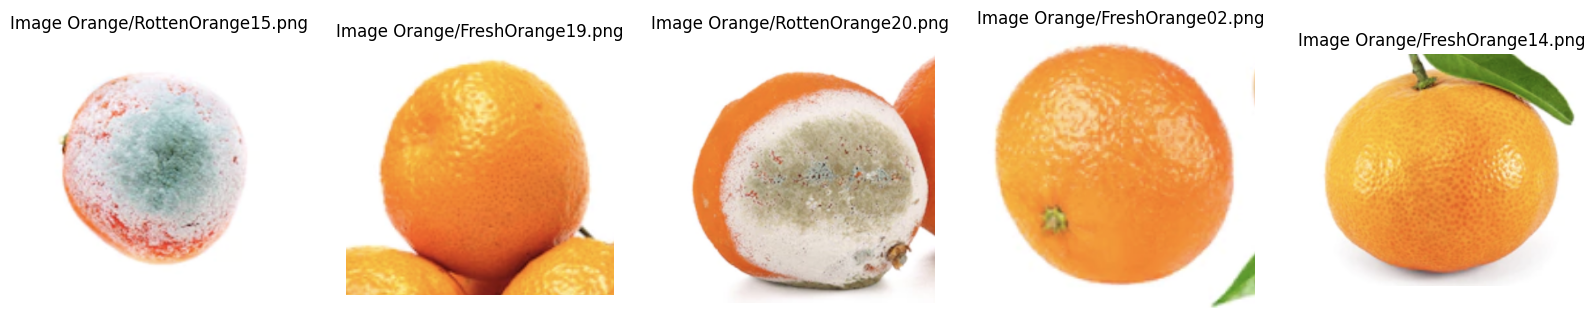

==================== - Finish: ShowRandomImage


In [ ]:
FileNameList, ImageList = ShowRandomImage(DatasetFiles, seedNo = 30)

##Segmentation on Specific Image by Hand Craft

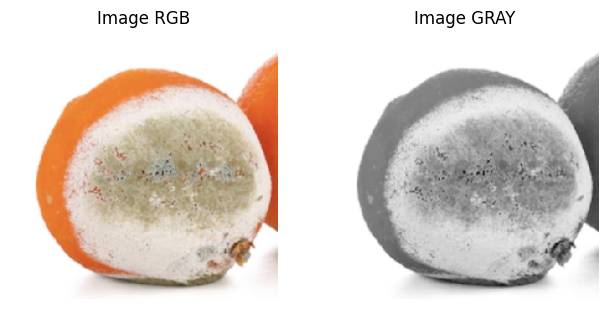

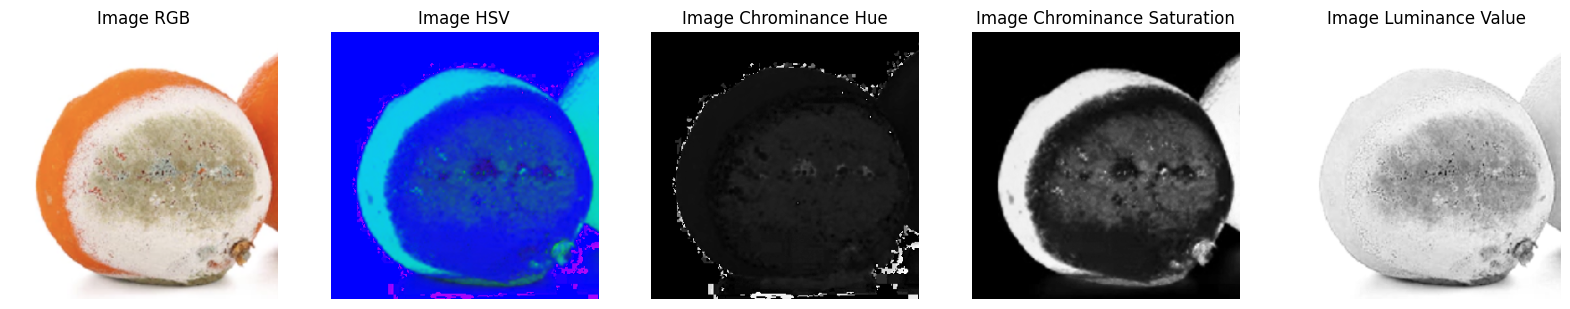

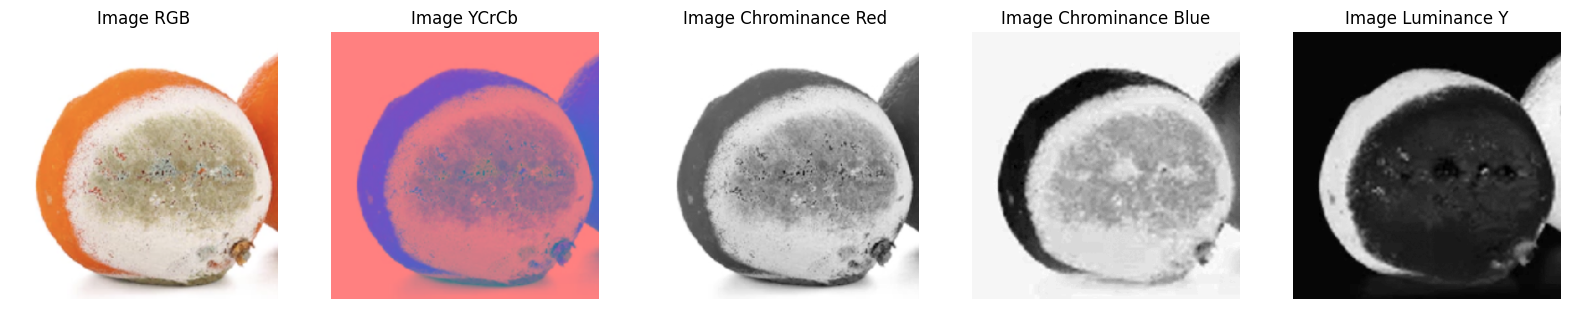

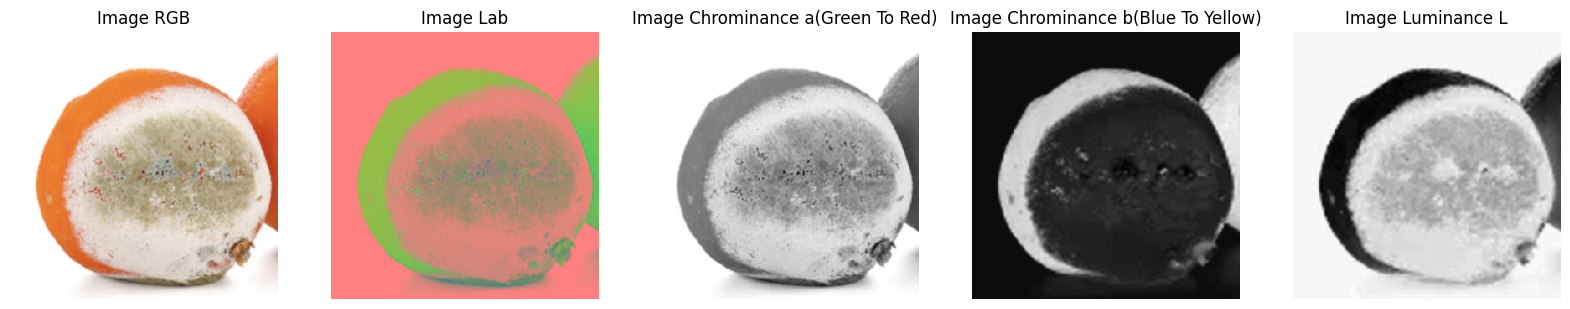

In [ ]:
AnImage = ResizeImage(ImageList[2], 0, 300)
AnImage = (AnImage*255).astype(np.uint8)
image_gray = ConvertColorSpaces(AnImage, ColorSpace = "GRAY")
image_hsv = ConvertColorSpaces(AnImage, ColorSpace = "HSV")
image_ycrcb = ConvertColorSpaces(AnImage, ColorSpace = "YCrCb")
image_lab = ConvertColorSpaces(AnImage, ColorSpace = "Lab")

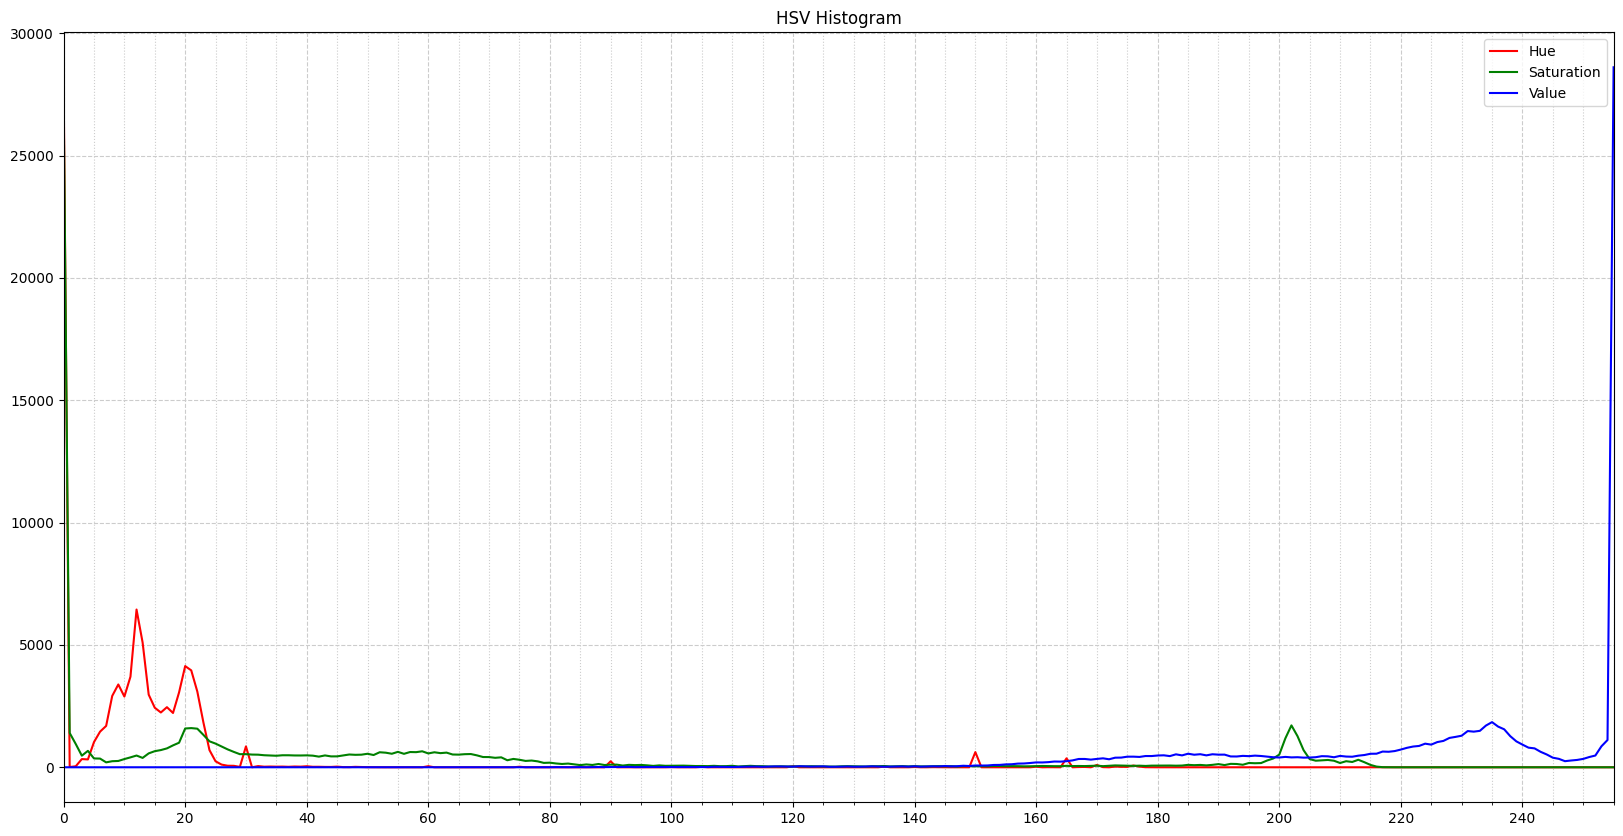

In [ ]:
ShowHistogram(image_hsv, Title = "HSV Histogram", ChannelList = ["Hue", "Saturation", "Value"])

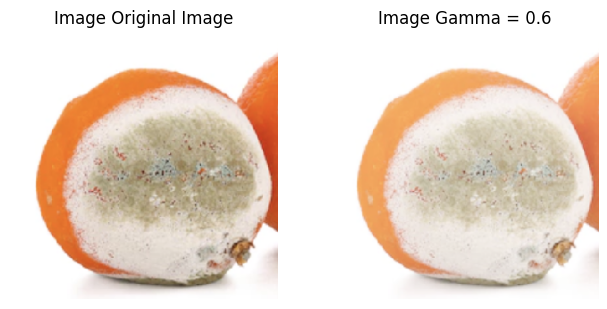

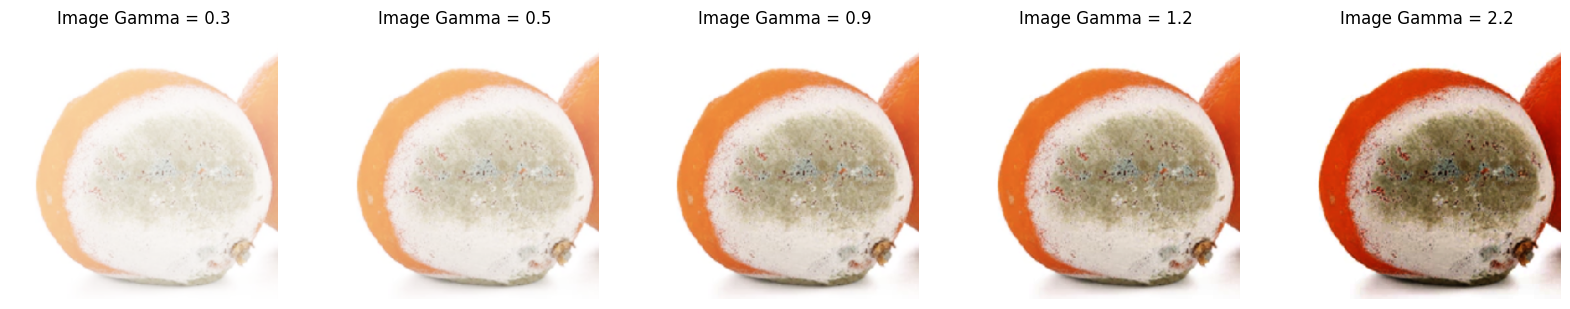

In [ ]:
AnImage_Gamma = IntensityTransformation(AnImage, gamma = 0.6, display = 1)

In [ ]:
hue = image_hsv[:,:,0]
saturation = image_hsv[:,:,1]
value = image_hsv[:,:,2]

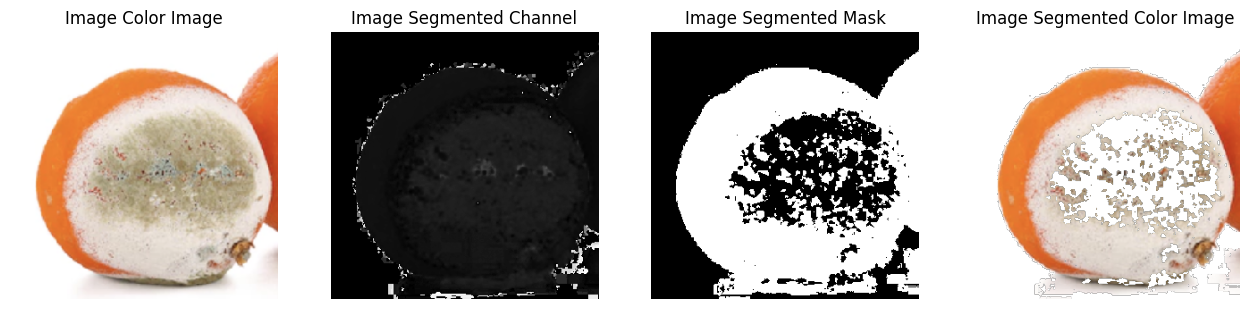

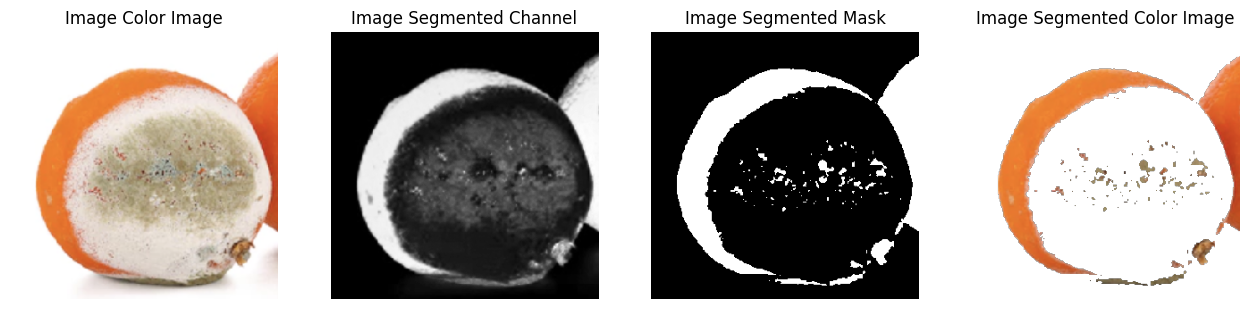

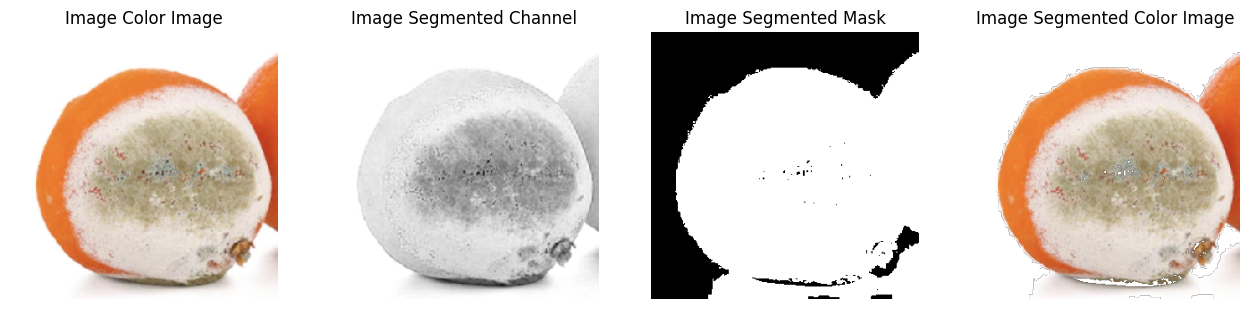

In [ ]:
image_mask_bythresh1 = SegmentByThresh(AnImage, hue, segment_range = [0, 20])
image_mask_bythresh2 = SegmentByThresh(AnImage, saturation, segment_range = [80,240])
image_mask_bythresh3 = SegmentByThresh(AnImage, value, segment_range = [120, 255])

Otsu Threshold : 75.0


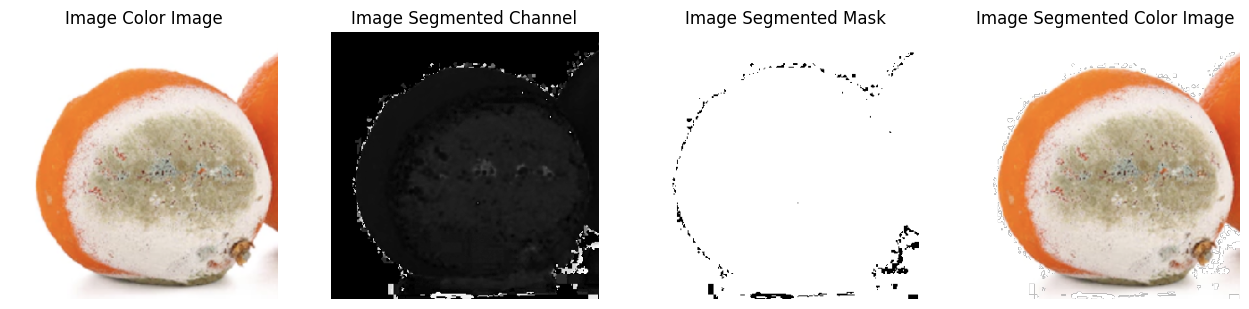

Otsu Threshold : 106.0


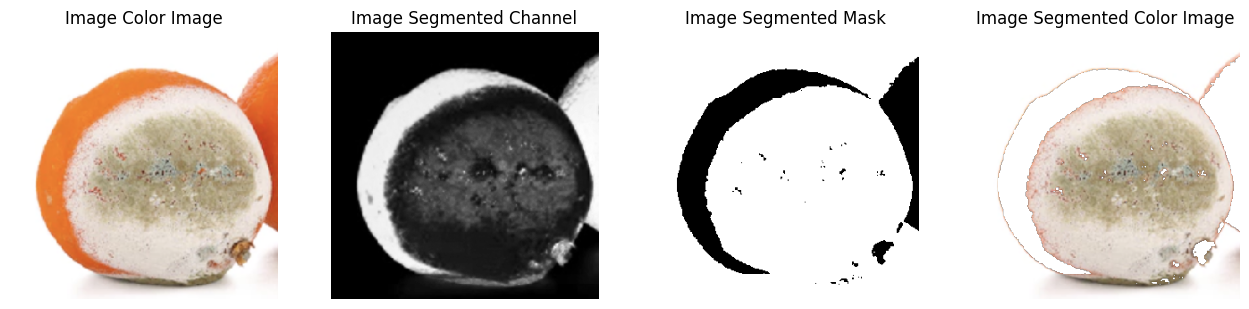

In [ ]:
image_mask_byauto1 = SegmentByThresh(AnImage, image_hsv[:,:,0])
image_mask_byauto2 = SegmentByThresh(AnImage, image_hsv[:,:,1])

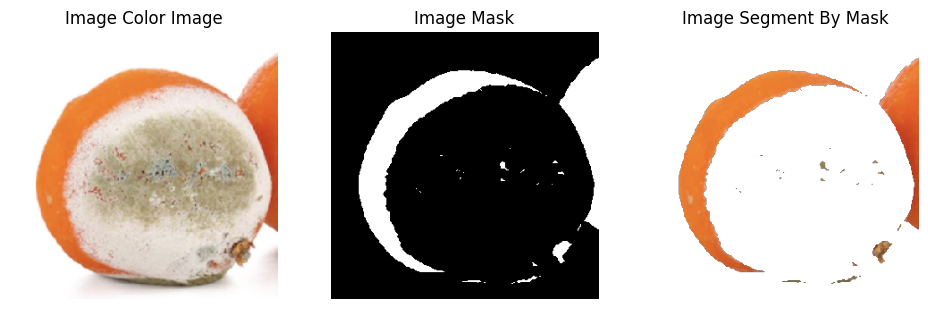

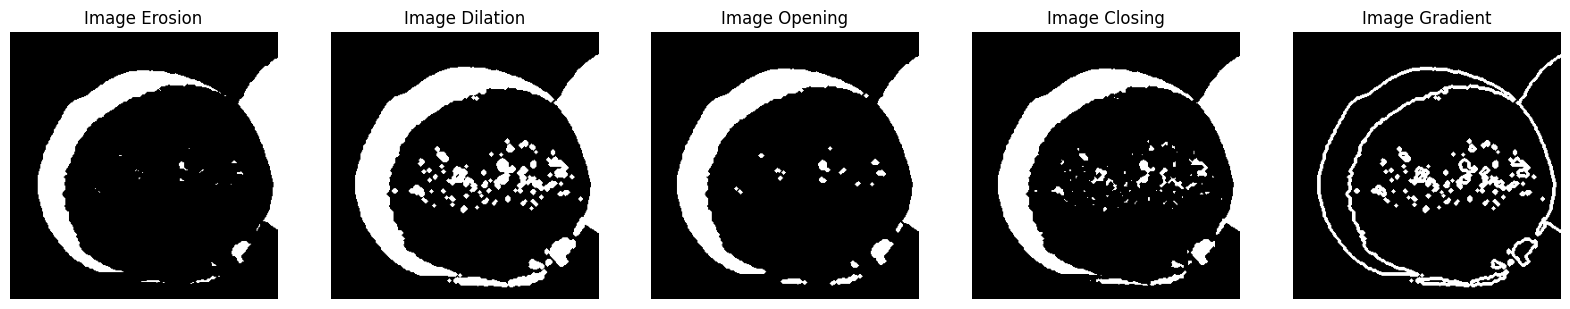

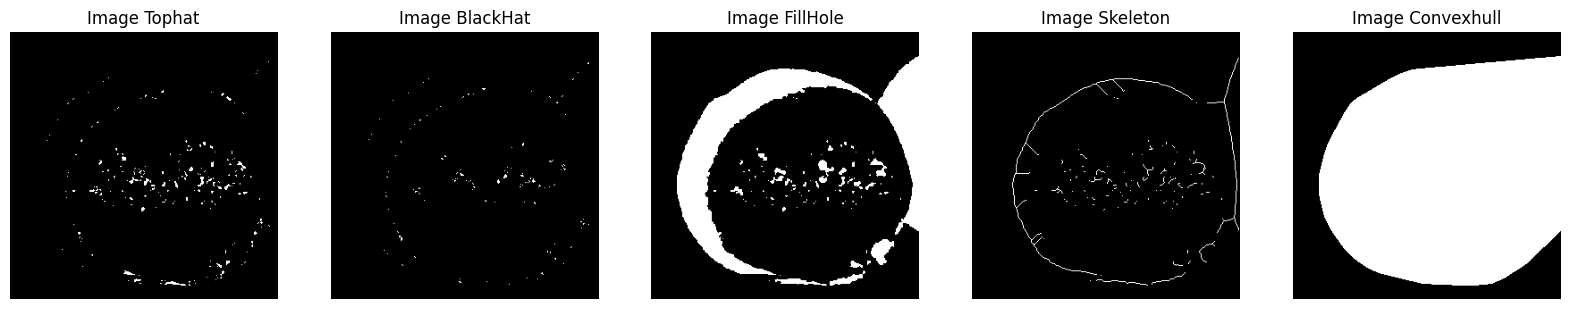

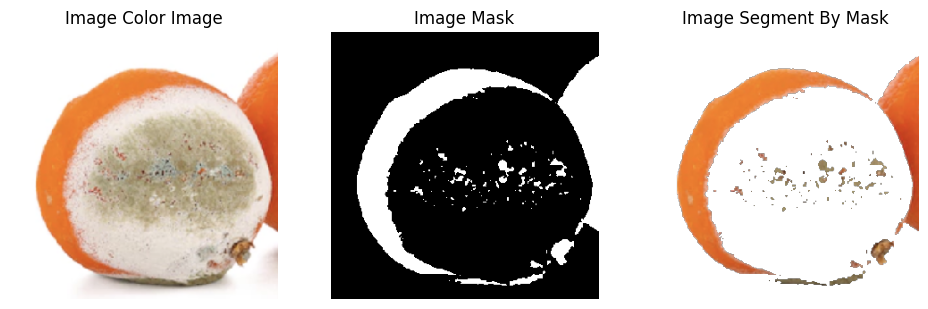

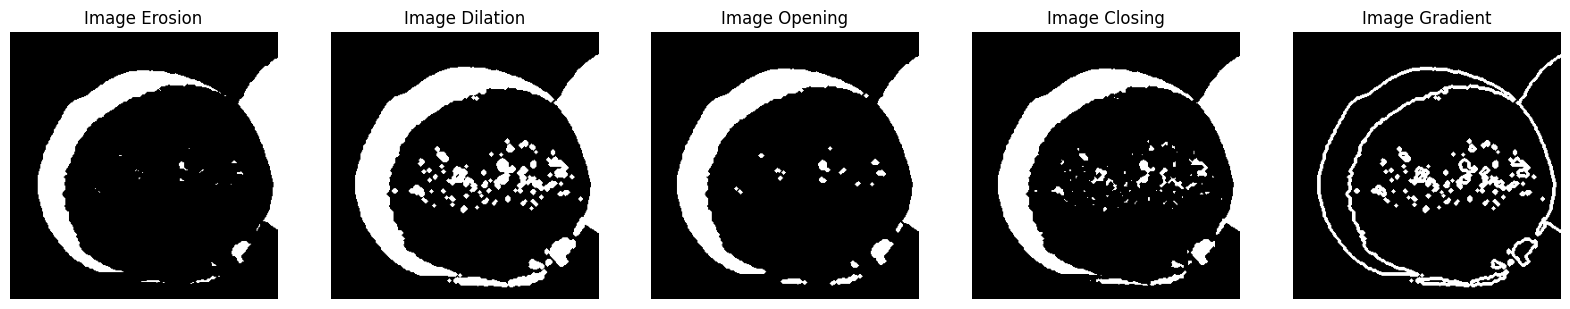

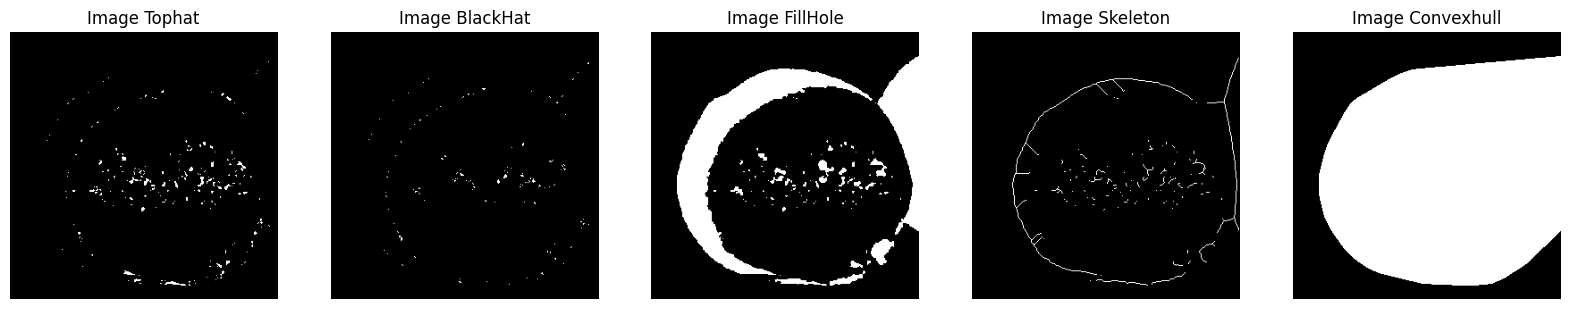

In [ ]:
image_mask_bythresh = image_mask_bythresh2.copy()
image_mask_adjust = Morphology(AnImage, image_mask_bythresh, morType = "erosion", size = 2, display = 1)
image_mask_adjust = Morphology(AnImage, image_mask_bythresh, morType = "fillhole", size = 2, display = 1)

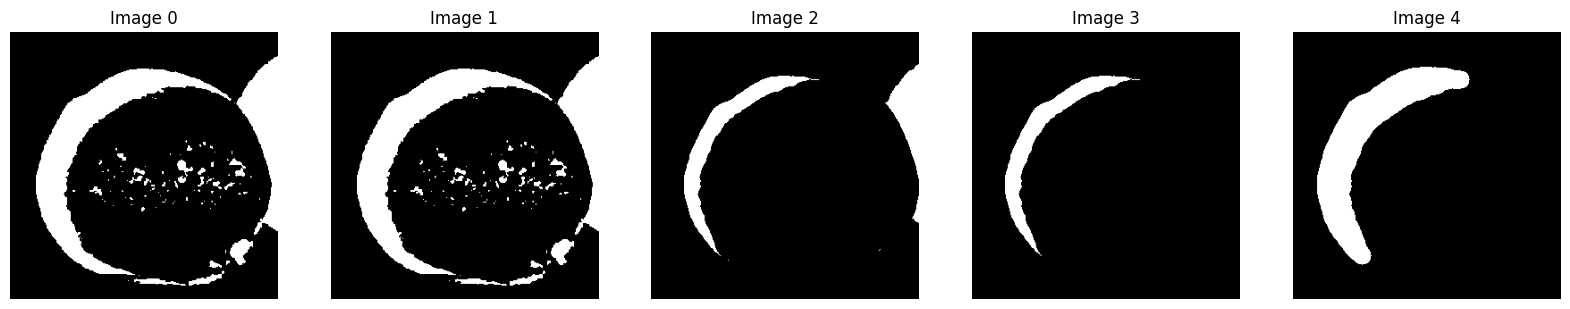

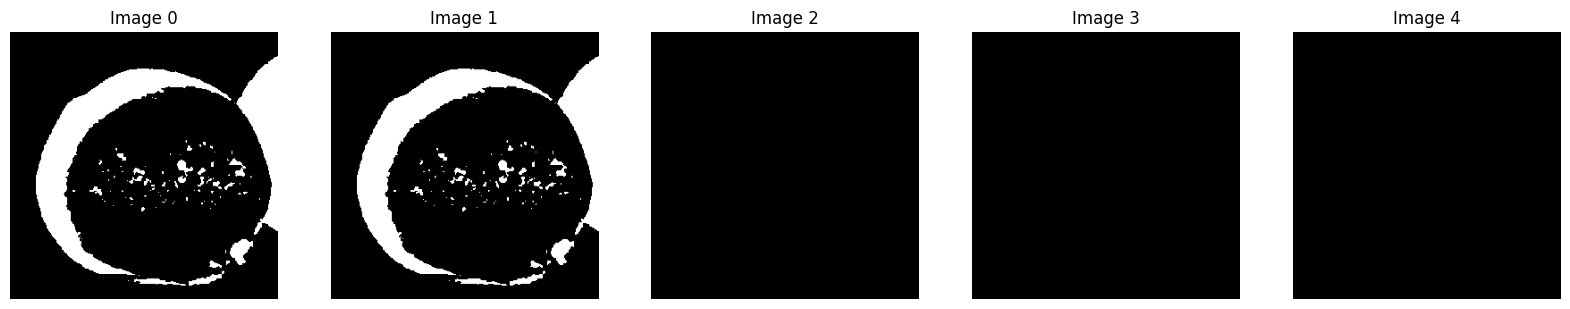

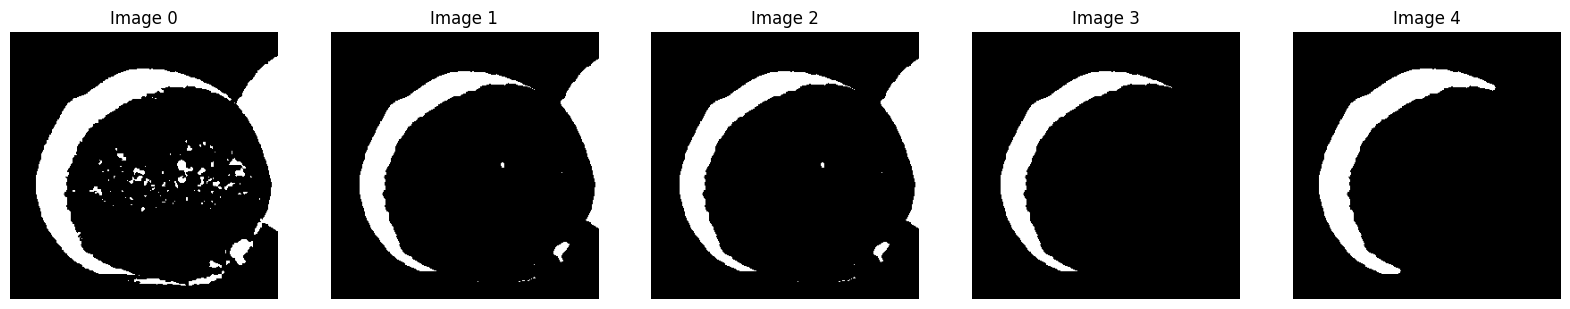

In [ ]:
image_mask_adjust = doOrangeMaskSegment(AnImage, image_mask_bythresh, display = 1)
image_mask_adjust = doOrangeMaskSegment2(AnImage, image_mask_bythresh, display = 1)
image_mask_adjust = doOrangeMaskSegment3(AnImage, image_mask_bythresh, display = 1)

Already Save Results to Folder /content/drive/MyDrive/CV/lab 2/data/Oranges (Output)
/content/drive/MyDrive/CV/lab 2/data/Oranges (Output)/RottenOrange15_rgbmask.jpg
/content/drive/MyDrive/CV/lab 2/data/Oranges (Output)/RottenOrange15_demo.jpg


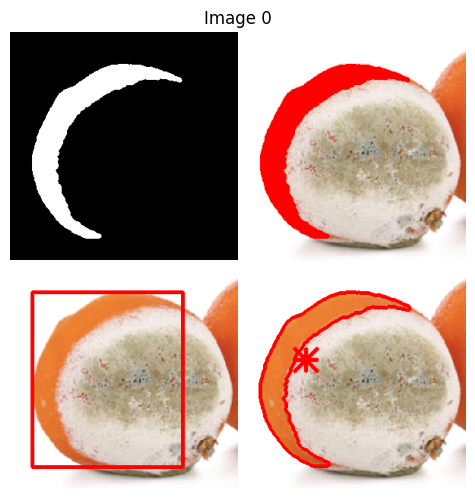

In [ ]:
image_mask = image_mask_adjust.copy()
result = GenerateOutput(AnImage, image_mask, FilePath = FileNameList[0], SaveFolderPath = "/content/drive/MyDrive/CV/lab 2/data/Oranges (Output)")
(image_output_rgbmask, image_output_fill, image_output_bbox, image_output_boundary, DemoImage) = result

ShowImage([DemoImage], 1, 3)

##Mass Segmentation

In [ ]:
for filepath in DatasetFiles:
  print("=" * 20, f"Process Image : {filepath}")
  AnImage = imread(filepath)
  AnImage = ResizeImage(AnImage, 0, 300)
  AnImage = (AnImage*255).astype(np.uint8)
  image_hsv = ConvertColorSpaces(AnImage, ColorSpace = "HSV", display = 0)

  hue = image_hsv[:,:,0]
  saturation = image_hsv[:,:,1]
  value = image_hsv[:,:,2]

  image_mask_bythresh = SegmentByThresh(AnImage, saturation, segment_range = [70, 255], display = 0)
  image_mask_adjust = doOrangeMaskSegment3(AnImage, image_mask_bythresh, display = 0)
  result = GenerateOutput(AnImage, image_mask_adjust, FilePath = filepath, SaveFolderPath = "/content/drive/MyDrive/CV/lab 2/data/Oranges (Output)")
  (image_output_rgbmask, image_output_fill, image_output_bbox, image_output_boundary, DemoImage) = result

  ShowImage([image_output_rgbmask, image_output_fill, image_output_bbox, image_output_boundary], 1, 5)

Output hidden; open in https://colab.research.google.com to view.

#BÀI 2: Thực hiện trích các đặc trưng màu sắc, kích thước, hình dạng v.v… để thành lập 1 table có 2 lớp là fresh và rotten


##Visual Feature Extraction

==================== - Begin: ShowRandomImage


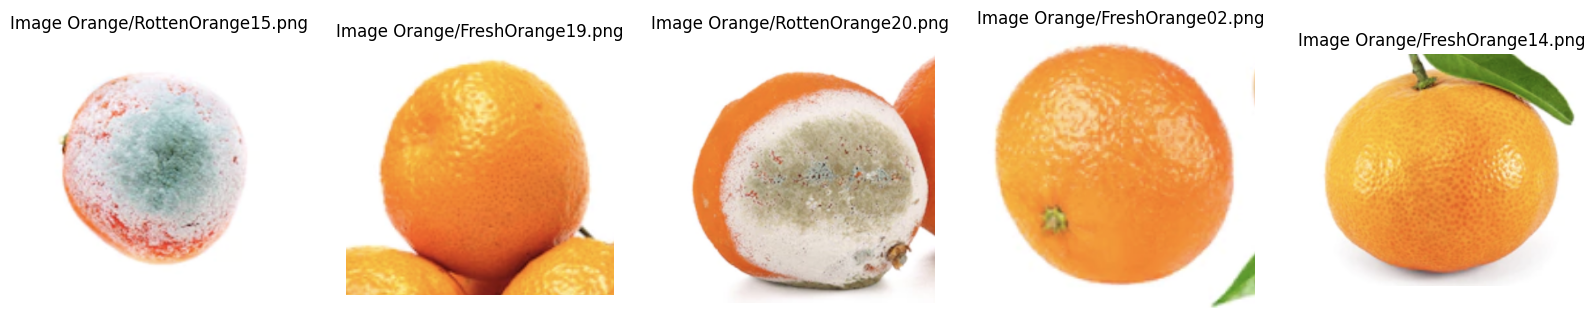

==================== - Finish: ShowRandomImage


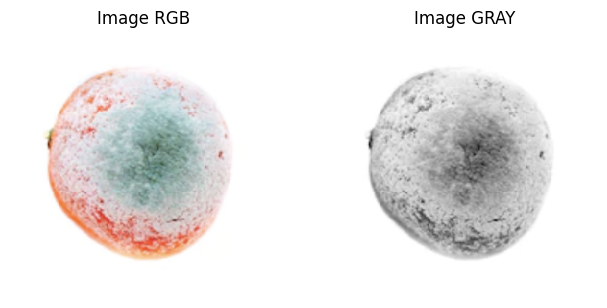

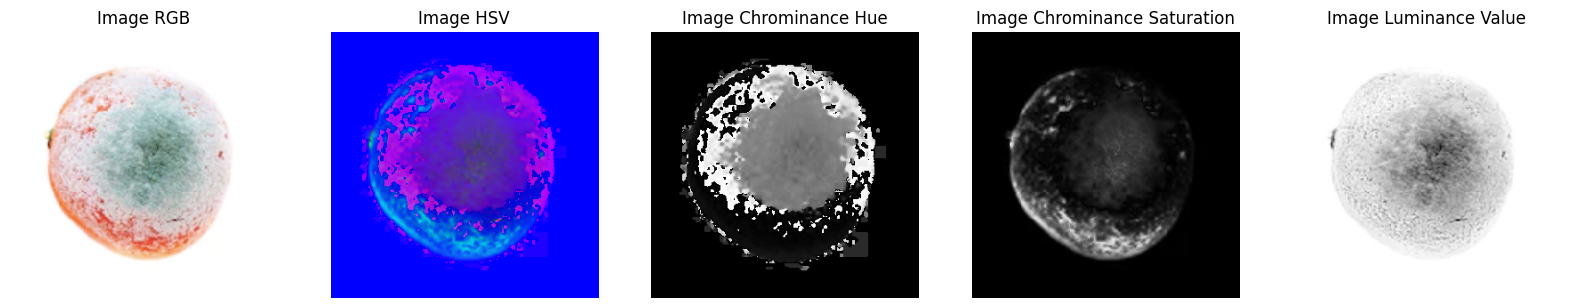

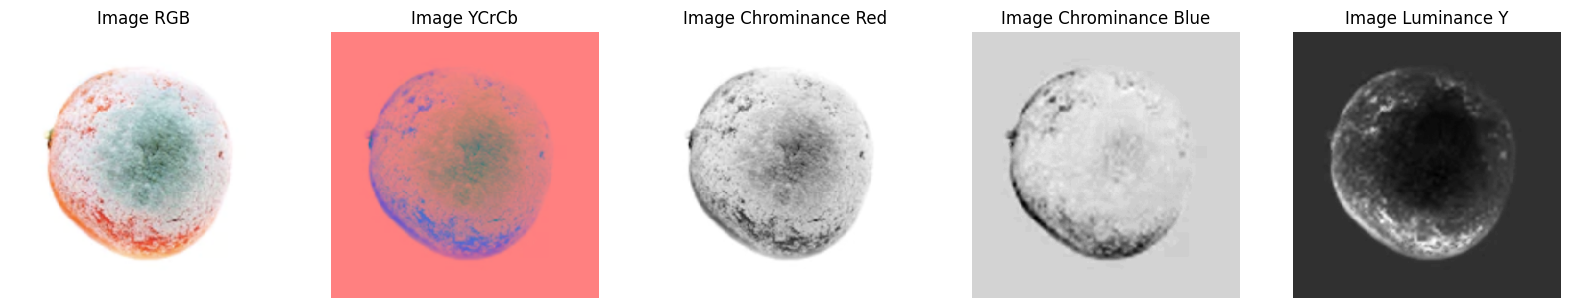

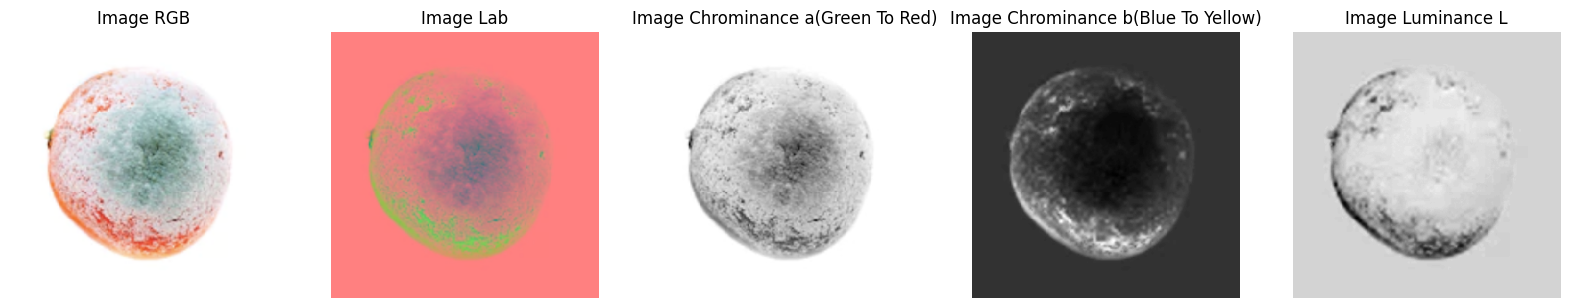

In [ ]:
########################################
FileNameList, ImageList = ShowRandomImage(DatasetFiles, seedNo = 30)
Idx = 0
AnImage = ResizeImage(ImageList[Idx], 0, 300)
AnImage = (AnImage*255).astype(np.uint8)
image_gray = ConvertColorSpaces(AnImage, ColorSpace = "GRAY")
image_hsv = ConvertColorSpaces(AnImage, ColorSpace = "HSV")
image_ycrcb = ConvertColorSpaces(AnImage, ColorSpace = "YCrCb")
image_lab = ConvertColorSpaces(AnImage, ColorSpace = "Lab")

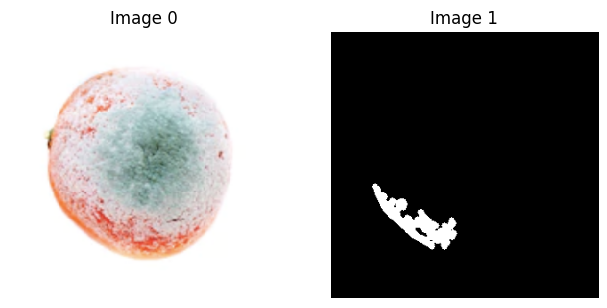

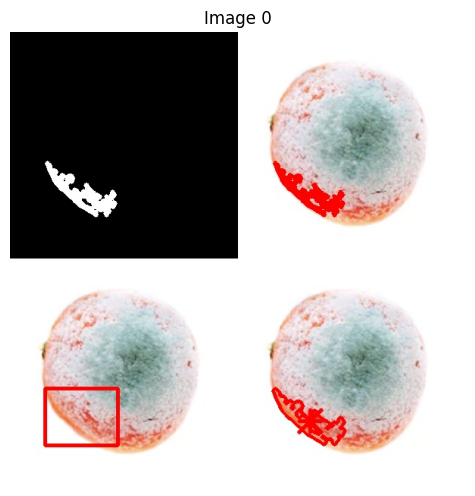

In [ ]:
########################################
filename = Path(FileNameList[Idx]).stem
image_mask = imread("/content/drive/MyDrive/CV/lab 2/data/Oranges (Output)/" + filename + "_mask.jpg")
image_mask = image_mask[:,:,0] > 200
image_demo = imread("/content/drive/MyDrive/CV/lab 2/data/Oranges (Output)/" + filename + "_demo.jpg")
ShowImage([AnImage, image_mask], 1, 5)
ShowImage([image_demo], 1, 3)

In [ ]:
hue = image_hsv[:,:,0]
saturation = image_hsv[:,:,1]
value = image_hsv[:,:,2]

Center Point at X = 95 and Y = 214
Contours Points are 
 [[ 49 171]
 [ 48 172]
 [ 47 172]
 [ 47 173]
 [ 46 174]
 [ 46 175]
 [ 47 176]
 [ 47 177]
 [ 48 178]
 [ 48 179]
 [ 48 180]
 [ 49 181]
 [ 49 182]
 [ 49 183]
 [ 50 184]
 [ 50 185]
 [ 51 186]
 [ 51 187]
 [ 52 188]
 [ 52 189]
 [ 53 190]
 [ 53 191]
 [ 54 192]
 [ 54 193]
 [ 55 194]
 [ 55 195]
 [ 55 196]
 [ 56 197]
 [ 56 198]
 [ 57 199]
 [ 58 200]
 [ 58 201]
 [ 59 202]
 [ 60 203]
 [ 61 204]
 [ 62 205]
 [ 63 206]
 [ 64 207]
 [ 64 208]
 [ 65 209]
 [ 66 210]
 [ 67 210]
 [ 68 211]
 [ 69 211]
 [ 70 212]
 [ 71 213]
 [ 72 214]
 [ 73 215]
 [ 74 216]
 [ 75 217]
 [ 76 218]
 [ 77 219]
 [ 78 220]
 [ 79 221]
 [ 80 221]
 [ 81 222]
 [ 82 223]
 [ 83 224]
 [ 83 225]
 [ 84 226]
 [ 85 226]
 [ 86 227]
 [ 87 228]
 [ 88 229]
 [ 89 230]
 [ 90 231]
 [ 91 232]
 [ 92 232]
 [ 93 233]
 [ 94 233]
 [ 95 234]
 [ 96 234]
 [ 97 235]
 [ 98 235]
 [ 99 236]
 [100 237]
 [101 237]
 [102 238]
 [103 239]
 [104 239]
 [105 240]
 [106 240]
 [107 241]
 [108 241]
 [109 242]
 [110 24

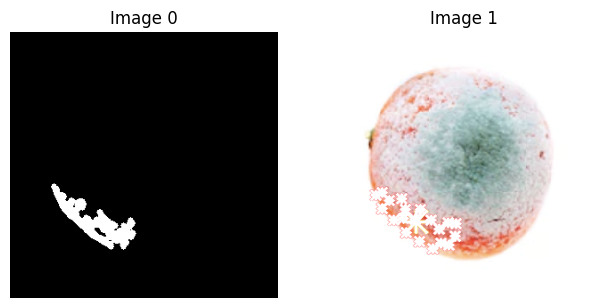

In [ ]:
CenterPoints, ContourPoints = GetContourCenter(AnImage, image_mask, display = 1)

Minor Length = 35.576213431800774 and Major Length = 115.11498815584555 and Orientation = 1.033725113717741
Bounding Box minr, minc, maxr, maxc are : [171, 46, 246, 142]


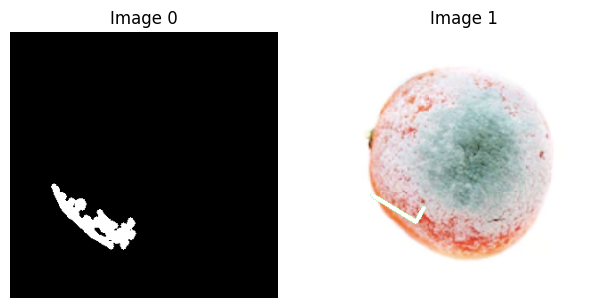

In [ ]:
minorLength, majorLength, orientation, bbox = GetMinorMajorLength(AnImage, image_mask, display = 1)

In [ ]:
Area, Perimeter, Solidity, Roundness = GetAreaPerimeterSolidity(AnImage, image_mask, display = 1)

Area : 2297, Perimeter : 460, Solidity : 0.6690940868045442, Roundness : 0.13641282278441882


In [ ]:
result_hue = GetMinMaxMeanQuantileIntensity(AnImage, image_mask, hue, display = 1)
(IntensityMinHue, IntensityMaxHue, IntensityMeanHue, IntensityQ1Hue, IntensityQ2Hue, IntensityQ3Hue) = result_hue

Min : 1.0, Max : 13.0 , Mean : 6.171690464019775
Q1 : 4.0, Q2 : 6.0, Q3 : 9.0


In [ ]:
result_saturation = GetMinMaxMeanQuantileIntensity(AnImage, image_mask, saturation, display = 1)
(IntensityMinSaturation, IntensityMaxSaturation, IntensityMeanSaturation, IntensityQ1Saturation, IntensityQ2Saturation, IntensityQ3Saturation) = result_saturation

Min : 71.0, Max : 203.0 , Mean : 117.95690155029297
Q1 : 91.0, Q2 : 111.0, Q3 : 140.0


In [ ]:
result_value = GetMinMaxMeanQuantileIntensity(AnImage, image_mask, value, display = 1)
(IntensityMinValue, IntensityMaxValue, IntensityMeanValue, IntensityQ1Value, IntensityQ2Value, IntensityQ3Value) = result_value

Min : 174.0, Max : 248.0 , Mean : 230.16064453125
Q1 : 222.0, Q2 : 234.0, Q3 : 240.0


In [ ]:
# Tạo một danh sách chứa các từ điển từ các biến thu thập được
feature_all = []
feature_for_classification  =[]

for filepath in DatasetFiles:
    print("=" * 20, f"Process Image : {filepath}")
    AnImage = imread(filepath)
    AnImage = ResizeImage(AnImage, 0, 300)

    image_gray = ConvertColorSpaces(AnImage, ColorSpace="GRAY", display=0)
    image_hsv = ConvertColorSpaces(AnImage, ColorSpace="HSV", display=0)

    filename = Path(filepath).stem
    image_mask = imread("/content/drive/MyDrive/CV/lab 2/data/Oranges (Output)/" + filename + "_mask.jpg")
    image_mask = image_mask[:, :, 0] > 200

    hue = image_hsv[:, :, 0]
    saturation = image_hsv[:, :, 1]
    value = image_hsv[:, :, 2]

    VisualFeatureDict = {}
    VisualFeatureDict2 = {}
    CenterPoints, ContourPoints = GetContourCenter(AnImage, image_mask, display=0)
    minorLength, majorLength, orientation, bbox = GetMinorMajorLength(AnImage, image_mask, display=0)
    Area, Perimeter, Solidity, Roundness = GetAreaPerimeterSolidity(AnImage, image_mask, display=0)

    result_hue = GetMinMaxMeanQuantileIntensity(AnImage, image_mask, hue, display=0)
    (IntensityMinHue, IntensityMaxHue, IntensityMeanHue, IntensityQ1Hue, IntensityQ2Hue,
     IntensityQ3Hue) = result_hue
    result_saturation = GetMinMaxMeanQuantileIntensity(AnImage, image_mask, saturation, display=0)
    (IntensityMinSaturation, IntensityMaxSaturation, IntensityMeanSaturation, IntensityQ1Saturation,
     IntensityQ2Saturation, IntensityQ3Saturation) = result_saturation
    result_value = GetMinMaxMeanQuantileIntensity(AnImage, image_mask, value, display=0)
    (IntensityMinValue, IntensityMaxValue, IntensityMeanValue, IntensityQ1Value, IntensityQ2Value,
     IntensityQ3Value) = result_value

    VisualFeatureDict["FileName"] = str(filename)
    VisualFeatureDict["CenterPoints"] = str(CenterPoints)
    VisualFeatureDict["ContourPoints"] = str(ContourPoints)
    VisualFeatureDict["minorLength"] = str(minorLength)
    VisualFeatureDict["majorLength"] = str(majorLength)
    VisualFeatureDict["orientation"] = str(orientation)
    VisualFeatureDict["bbox"] = str(bbox)
    VisualFeatureDict["Area"] = str(Area)
    VisualFeatureDict["Perimeter"] = str(Perimeter)
    VisualFeatureDict["Solidity"] = str(Solidity)
    VisualFeatureDict["Roundness"] = str(Roundness)
    VisualFeatureDict["IntensityMinHue"] = str(IntensityMinHue)
    VisualFeatureDict["IntensityMaxHue"] = str(IntensityMaxHue)
    VisualFeatureDict["IntensityMeanHue"] = str(IntensityMeanHue)
    VisualFeatureDict["IntensityQ1Hue"] = str(IntensityQ1Hue)
    VisualFeatureDict["IntensityQ2Hue"] = str(IntensityQ2Hue)
    VisualFeatureDict["IntensityQ3Hue"] = str(IntensityQ3Hue)
    VisualFeatureDict["IntensityMinSaturation"] = str(IntensityMinSaturation)
    VisualFeatureDict["IntensityMaxSaturation"] = str(IntensityMaxSaturation)
    VisualFeatureDict["IntensityMeanSaturation"] = str(IntensityMeanSaturation)
    VisualFeatureDict["IntensityQ1Saturation"] = str(IntensityQ1Saturation)
    VisualFeatureDict["IntensityQ2Saturation"] = str(IntensityQ2Saturation)
    VisualFeatureDict["IntensityQ3Saturation"] = str(IntensityQ3Saturation)
    VisualFeatureDict["IntensityMinValue"] = str(IntensityMinValue)
    VisualFeatureDict["IntensityMaxValue"] = str(IntensityMaxValue)
    VisualFeatureDict["IntensityMeanValue"] = str(IntensityMeanValue)
    VisualFeatureDict["IntensityQ1Value"] = str(IntensityQ1Value)
    VisualFeatureDict["IntensityQ2Value"] = str(IntensityQ2Value)
    VisualFeatureDict["IntensityQ3Value"] = str(IntensityQ3Value)




    VisualFeatureDict2["FileName"] = str(filename)
    VisualFeatureDict2["Area"] = str(Area)
    VisualFeatureDict2["Solidity"] = str(Solidity)
    VisualFeatureDict2["Roundness"] = str(Roundness)
    VisualFeatureDict2["IntensityQ2Value"] = str(IntensityQ2Value)
    VisualFeatureDict2["IntensityQ3Value"] = str(IntensityQ3Value)


    feature_all.append(VisualFeatureDict)
    feature_for_classification.append(VisualFeatureDict2)

# Tạo DataFrame
df = pd.DataFrame(feature_all)
df2 = pd.DataFrame(feature_for_classification)



==================== Process Image : Orange/FreshOrange01.png
==================== Process Image : Orange/FreshOrange02.png
==================== Process Image : Orange/FreshOrange03.png
==================== Process Image : Orange/FreshOrange04.png
==================== Process Image : Orange/FreshOrange05.png
==================== Process Image : Orange/FreshOrange06.png
==================== Process Image : Orange/FreshOrange07.png
==================== Process Image : Orange/FreshOrange08.png
==================== Process Image : Orange/FreshOrange09.png
==================== Process Image : Orange/FreshOrange10.png
==================== Process Image : Orange/FreshOrange11.png
==================== Process Image : Orange/FreshOrange12.png
==================== Process Image : Orange/FreshOrange13.png
==================== Process Image : Orange/FreshOrange14.png
==================== Process Image : Orange/FreshOrange15.png
==================== Process Image : Orange/FreshOrange16.png
========

In [ ]:
df2


FileName   Area            Solidity            Roundness  \
0    FreshOrange01  62488  0.9911178784418221   0.8502755941121815   
1    FreshOrange02  52843  0.9912771066256472   0.8555502303962473   
2    FreshOrange03  59994  0.9913414190819261   0.8478017277926253   
3    FreshOrange04  69836  0.9444189002785817  0.41170250432744754   
4    FreshOrange05  58365  0.9002776492364646   0.5001198216098325   
5    FreshOrange06  64067  0.9921485427571468   0.8609765125567183   
6    FreshOrange07  55094  0.9935798016230839   0.8799681007099979   
7    FreshOrange08  58572  0.9305562175301463   0.5941684524106152   
8    FreshOrange09  63372   0.935380073800738  0.40399227612456956   
9    FreshOrange10  63111  0.9434337394424097    0.581338706724718   
10   FreshOrange11  70899  0.9815999335437781   0.7349796858668249   
11   FreshOrange12  53211  0.9929463136091362   0.8753634709830731   
12   FreshOrange13  61639  0.9830624710929651    0.788711438566152   
13   FreshOrange14  68657     0.9608021495144   0.6041696099648519   
14   FreshOrange15  75968  0.9435026143547326   0.6563657959728979   
15   FreshOrange16  56349  0.9924092990489609     0.85886396222094   
16   FreshOrange17  62119  0.9909391101823345   0.8559089676197225   
17   FreshOrange18  56985  0.9919060052219321   0.8666478225437321   
18   FreshOrange19  64765  0.9226177756884197   0.5504059043070003   
19   FreshOrange20  61694  0.9055734143584776   0.5132737185247718   
20  RottenOrange01  38355  0.5885467016526262   0.2301944183608658   
21  RottenOrange02  37160  0.7375210876252853  0.16844460028662422   
22  RottenOrange03  67763  0.9789511701820283   0.5601138809402821   
23  RottenOrange04  67830  0.9844559585492227   0.5670883699639823   
24  RottenOrange05  63775  0.9922981173175666   0.8732313382642556   
25  RottenOrange06  73749  0.9877450980392157   0.8342280302366467   
26  RottenOrange07  67494  0.9564391792313797  0.49348010424353805   
27  RottenOrange08  18799  0.7784909723372536   0.2252914439957982   
28  RottenOrange09  34756  0.8379785900279679  0.26909200621084123   
29  RottenOrange10  39772  0.7802562140741177  0.17375431511794295   
30  RottenOrange11  69444  0.9222310756972112   0.2313908286083121   
31  RottenOrange12  64907  0.9929324297449862   0.8650932845158524   
32  RottenOrange13  61029  0.9907948568088837   0.8034465503130087   
33  RottenOrange14  61763  0.9906330697547596   0.8114477066575766   
34  RottenOrange15   2297  0.6690940868045442  0.13641282278441882   
35  RottenOrange16  29189  0.8689271255060729   0.3397801356921541   
36  RottenOrange17   1991  0.8559759243336199   0.4771008160254212   
37  RottenOrange18  14960   0.554361520788557  0.16636996624758132   
38  RottenOrange19  20944   0.853185595567867   0.3802093919701404   
39  RottenOrange20  10275  0.3462393853619086  0.17058985078945765   

      IntensityQ2Value    IntensityQ3Value  
0   0.9450980424880981  0.9529411792755127  
1   0.9450980424880981  0.9529411792755127  
2   0.9490196108818054  0.9529411792755127  
3   0.9450980424880981  0.9529411792755127  
4   0.9254902005195618  0.9490196108818054  
5   0.9019607901573181  0.9372549057006836  
6   0.9176470637321472  0.9490196108818054  
7   0.9411764740943909  0.9450980424880981  
8   0.9450980424880981  0.9529411792755127  
9   0.9254902005195618  0.9529411792755127  
10  0.9411764740943909  0.9450980424880981  
11  0.9176470637321472  0.9490196108818054  
12  0.9254902005195618  0.9411764740943909  
13  0.9411764740943909    0.95686274766922  
14  0.9372549057006836  0.9490196108818054  
15  0.9411764740943909  0.9490196108818054  
16  0.9450980424880981  0.9529411792755127  
17  0.9019607901573181  0.9372549057006836  
18  0.9450980424880981    0.95686274766922  
19  0.9254902005195618  0.9490196108818054  
20  0.8509804010391235  0.9254902005195618  
21  0.8705882430076599  0.9098039269447327  
22  0.7921568751335144  0.9333333373069763  
23  0.7843137383460999  0.9019607901573181  
24  0.85098040

In [ ]:
print(df2.dtypes)

df2['Area'] = df2['Area'].astype(float)
df2['Solidity'] = df2['Solidity'].astype(float)
df2['Roundness'] = df2['Roundness'].astype(float)
df2['IntensityQ2Value'] = df2['IntensityQ2Value'].astype(float)
df2['IntensityQ3Value'] = df2['IntensityQ3Value'].astype(float)

print(df2.dtypes)


FileName            object
Area                object
Solidity            object
Roundness           object
IntensityQ2Value    object
IntensityQ3Value    object
dtype: object
FileName             object
Area                float64
Solidity            float64
Roundness           float64
IntensityQ2Value    float64
IntensityQ3Value    float64
dtype: object


In [ ]:
def classify_orange(area, solidity, roundness,intensityQ2Value,intensityQ3Value):
    # Sử dụng các ngưỡng dựa trên giá trị trung bình của dữ liệu
    area_threshold = 52000  # Giá trị trung bình của diện tích
    solidity_threshold = 0.9  # Giá trị trung bình của độ đồng đều
    roundness_threshold = 0.4  # Giá trị trung bình của độ tròn
    intensityQ2Value_threshold = 0.9
    intensityQ3Value_threshold = 0.92

    if area >= area_threshold and solidity >= solidity_threshold and roundness >= roundness_threshold and intensityQ2Value >= intensityQ2Value_threshold and intensityQ3Value >= intensityQ3Value_threshold:
        return "fresh"
    else:
        return "rotten"

In [ ]:
df2["class"] = df2.apply(lambda row: classify_orange(row["Area"], row["Solidity"], row["Roundness"],row["IntensityQ2Value"],row["IntensityQ3Value"]), axis=1)

In [ ]:
display(df2)

FileName     Area  Solidity  Roundness  IntensityQ2Value  \
0    FreshOrange01  62488.0  0.991118   0.850276          0.945098   
1    FreshOrange02  52843.0  0.991277   0.855550          0.945098   
2    FreshOrange03  59994.0  0.991341   0.847802          0.949020   
3    FreshOrange04  69836.0  0.944419   0.411703          0.945098   
4    FreshOrange05  58365.0  0.900278   0.500120          0.925490   
5    FreshOrange06  64067.0  0.992149   0.860977          0.901961   
6    FreshOrange07  55094.0  0.993580   0.879968          0.917647   
7    FreshOrange08  58572.0  0.930556   0.594168          0.941176   
8    FreshOrange09  63372.0  0.935380   0.403992          0.945098   
9    FreshOrange10  63111.0  0.943434   0.581339          0.925490   
10   FreshOrange11  70899.0  0.981600   0.734980          0.941176   
11   FreshOrange12  53211.0  0.992946   0.875363          0.917647   
12   FreshOrange13  61639.0  0.983062   0.788711          0.925490   
13   FreshOrange14  68657.0  0.960802   0.604170          0.941176   
14   FreshOrange15  75968.0  0.943503   0.656366          0.937255   
15   FreshOrange16  56349.0  0.992409   0.858864          0.941176   
16   FreshOrange17  62119.0  0.990939   0.855909          0.945098   
17   FreshOrange18  56985.0  0.991906   0.866648          0.901961   
18   FreshOrange19  64765.0  0.922618   0.550406          0.945098   
19   FreshOrange20  61694.0  0.905573   0.513274          0.925490   
20  RottenOrange01  38355.0  0.588547   0.230194          0.850980   
21  RottenOrange02  37160.0  0.737521   0.168445          0.870588   
22  RottenOrange03  67763.0  0.978951   0.560114          0.792157   
23  RottenOrange04  67830.0  0.984456   0.567088          0.784314   
24  RottenOrange05  63775.0  0.992298   0.873231          0.850980   
25  RottenOrange06  73749.0  0.987745   0.834228          0.831373   
26  RottenOrange07  67494.0  0.956439   0.493480          0.580392   
27  RottenOrange08  18799.0  0.778491   0.225291          0.949020   
28  RottenOrange09  34756.0  0.837979   0.269092          0.913725   
29  RottenOrange10  39772.0  0.780256   0.173754          0.756863   
30  RottenOrange11  69444.0  0.922231   0.231391          0.843137   
31  RottenOrange12  64907.0  0.992932   0.865093          0.901961   
32  RottenOrange13  61029.0  0.990795   0.803447          0.815686   
33  RottenOrange14  61763.0  0.990633   0.811448          0.764706   
34  RottenOrange15   2297.0  0.669094   0.136413          0.917647   
35  RottenOrange16  29189.0  0.868927   0.339780          0.819608   
36  RottenOrange17   1991.0  0.855976   0.477101          0.890196   
37  RottenOrange18  14960.0  0.554362   0.166370          0.784314   
38  RottenOrange19  20944.0  0.853186   0.380209          0.721569   
39  RottenOrange20  10275.0  0.346239   0.170590          0.917647   

    IntensityQ3Value   class  
0           0.952941   fresh  
1           0.952941   fresh  
2           0.952941   fresh  
3           0.952941   fresh  
4           0.949020   fresh  
5           0.937255   fresh  
6           0.949020   fresh  
7           0.945098   fresh  
8           0.952941   fresh  
9           0.952941   fresh  
10          0.945098   fresh  
11          0.949020   fresh  
12          0.941176   fresh  
13          0.956863   fresh  
14          0.949020   fresh  
15          0.949020   fresh  
16          0.952941   fresh  
17          0.937255   fresh  
18          0.956863   fresh  
19          0.949020   fresh  
20          0.925490  rotten  
21          0.909804  rotten  
22          0.933333  rotten  
23          0.901961  rotten  
24          0.905882  rotten  
25          0.945098  rotten  
26          0.733333  rotten  
27          0.960784  rotten  
28          0.933333  rotten  
29          0.819608  rotten  
30          0.890196  rotten  
31          0.917647  rotten  
32          0.874510  rotten  
33          0.901961  rotten  
34          0.941176  rotten  
35          0.925490  r

In [ ]:
#Save data frame to CSV
df.to_csv("Orange.csv", index=False)
df2.to_csv("Orange2.csv", index=False)

#BÀI 3: ML

## Load data

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns

In [93]:
df = pd.read_csv('/content/drive/MyDrive/CV/lab 2/data/Orange2.csv')

df

FileName     Area  Solidity  Roundness  IntensityQ2Value  \
0    FreshOrange01  62488.0  0.991118   0.850276          0.945098   
1    FreshOrange02  52843.0  0.991277   0.855550          0.945098   
2    FreshOrange03  59994.0  0.991341   0.847802          0.949020   
3    FreshOrange04  69836.0  0.944419   0.411703          0.945098   
4    FreshOrange05  58365.0  0.900278   0.500120          0.925490   
5    FreshOrange06  64067.0  0.992149   0.860977          0.901961   
6    FreshOrange07  55094.0  0.993580   0.879968          0.917647   
7    FreshOrange08  58572.0  0.930556   0.594168          0.941176   
8    FreshOrange09  63372.0  0.935380   0.403992          0.945098   
9    FreshOrange10  63111.0  0.943434   0.581339          0.925490   
10   FreshOrange11  70899.0  0.981600   0.734980          0.941176   
11   FreshOrange12  53211.0  0.992946   0.875363          0.917647   
12   FreshOrange13  61639.0  0.983062   0.788711          0.925490   
13   FreshOrange14  68657.0  0.960802   0.604170          0.941176   
14   FreshOrange15  75968.0  0.943503   0.656366          0.937255   
15   FreshOrange16  56349.0  0.992409   0.858864          0.941176   
16   FreshOrange17  62119.0  0.990939   0.855909          0.945098   
17   FreshOrange18  56985.0  0.991906   0.866648          0.901961   
18   FreshOrange19  64765.0  0.922618   0.550406          0.945098   
19   FreshOrange20  61694.0  0.905573   0.513274          0.925490   
20  RottenOrange01  38355.0  0.588547   0.230194          0.850980   
21  RottenOrange02  37160.0  0.737521   0.168445          0.870588   
22  RottenOrange03  67763.0  0.978951   0.560114          0.792157   
23  RottenOrange04  67830.0  0.984456   0.567088          0.784314   
24  RottenOrange05  63775.0  0.992298   0.873231          0.850980   
25  RottenOrange06  73749.0  0.987745   0.834228          0.831373   
26  RottenOrange07  67494.0  0.956439   0.493480          0.580392   
27  RottenOrange08  18799.0  0.778491   0.225291          0.949020   
28  RottenOrange09  34756.0  0.837979   0.269092          0.913725   
29  RottenOrange10  39772.0  0.780256   0.173754          0.756863   
30  RottenOrange11  69444.0  0.922231   0.231391          0.843137   
31  RottenOrange12  64907.0  0.992932   0.865093          0.901961   
32  RottenOrange13  61029.0  0.990795   0.803447          0.815686   
33  RottenOrange14  61763.0  0.990633   0.811448          0.764706   
34  RottenOrange15   2297.0  0.669094   0.136413          0.917647   
35  RottenOrange16  29189.0  0.868927   0.339780          0.819608   
36  RottenOrange17   1991.0  0.855976   0.477101          0.890196   
37  RottenOrange18  14960.0  0.554362   0.166370          0.784314   
38  RottenOrange19  20944.0  0.853186   0.380209          0.721569   
39  RottenOrange20  10275.0  0.346239   0.170590          0.917647   

    IntensityQ3Value   class  
0           0.952941   fresh  
1           0.952941   fresh  
2           0.952941   fresh  
3           0.952941   fresh  
4           0.949020   fresh  
5           0.937255   fresh  
6           0.949020   fresh  
7           0.945098   fresh  
8           0.952941   fresh  
9           0.952941   fresh  
10          0.945098   fresh  
11          0.949020   fresh  
12          0.941176   fresh  
13          0.956863   fresh  
14          0.949020   fresh  
15          0.949020   fresh  
16          0.952941   fresh  
17          0.937255   fresh  
18          0.956863   fresh  
19          0.949020   fresh  
20          0.925490  rotten  
21          0.909804  rotten  
22          0.933333  rotten  
23          0.901961  rotten  
24          0.905882  rotten  
25          0.945098  rotten  
26          0.733333  rotten  
27          0.960784  rotten  
28          0.933333  rotten  
29          0.819608  rotten  
30          0.890196  rotten  
31          0.917647  rotten  
32          0.874510  rotten  
33          0.901961  rotten  
34          0.941176  rotten  
35          0.925490  r

## EDA

In [94]:
#Get columns list
df.columns.tolist()

['FileName',
 'Area',
 'Solidity',
 'Roundness',
 'IntensityQ2Value',
 'IntensityQ3Value',
 'class']

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FileName          40 non-null     object 
 1   Area              40 non-null     float64
 2   Solidity          40 non-null     float64
 3   Roundness         40 non-null     float64
 4   IntensityQ2Value  40 non-null     float64
 5   IntensityQ3Value  40 non-null     float64
 6   class             40 non-null     object 
dtypes: float64(5), object(2)
memory usage: 2.3+ KB


In [96]:
df.describe()

Area   Solidity  Roundness  IntensityQ2Value  IntensityQ3Value
count     40.000000  40.000000  40.000000         40.000000         40.000000
mean   52157.000000   0.898649   0.571684          0.880490          0.920686
std    20389.238245   0.143315   0.260339          0.080456          0.052654
min     1991.000000   0.346239   0.136413          0.580392          0.733333
25%    39417.750000   0.865689   0.370102          0.840196          0.915686
50%    61334.000000   0.950429   0.574214          0.917647          0.941176
75%    64800.500000   0.990984   0.848420          0.941176          0.950000
max    75968.000000   0.993580   0.879968          0.949020          0.960784

In [97]:
# Get categorical columns and numerical columns
categorical_cols = [feature for feature in df.columns if df[feature].dtype == "O"]
numerical_cols = [feature for feature in df.columns if df[feature].dtype != "O"]

print(f'Categorical columns :{categorical_cols}\n')
print(f'Numerical columns :{numerical_cols}')

Categorical columns :['FileName', 'class']

Numerical columns :['Area', 'Solidity', 'Roundness', 'IntensityQ2Value', 'IntensityQ3Value']


array([[<Axes: title={'center': 'Area'}>,
        <Axes: title={'center': 'Solidity'}>],
       [<Axes: title={'center': 'Roundness'}>,
        <Axes: title={'center': 'IntensityQ2Value'}>],
       [<Axes: title={'center': 'IntensityQ3Value'}>, <Axes: >]],
      dtype=object)

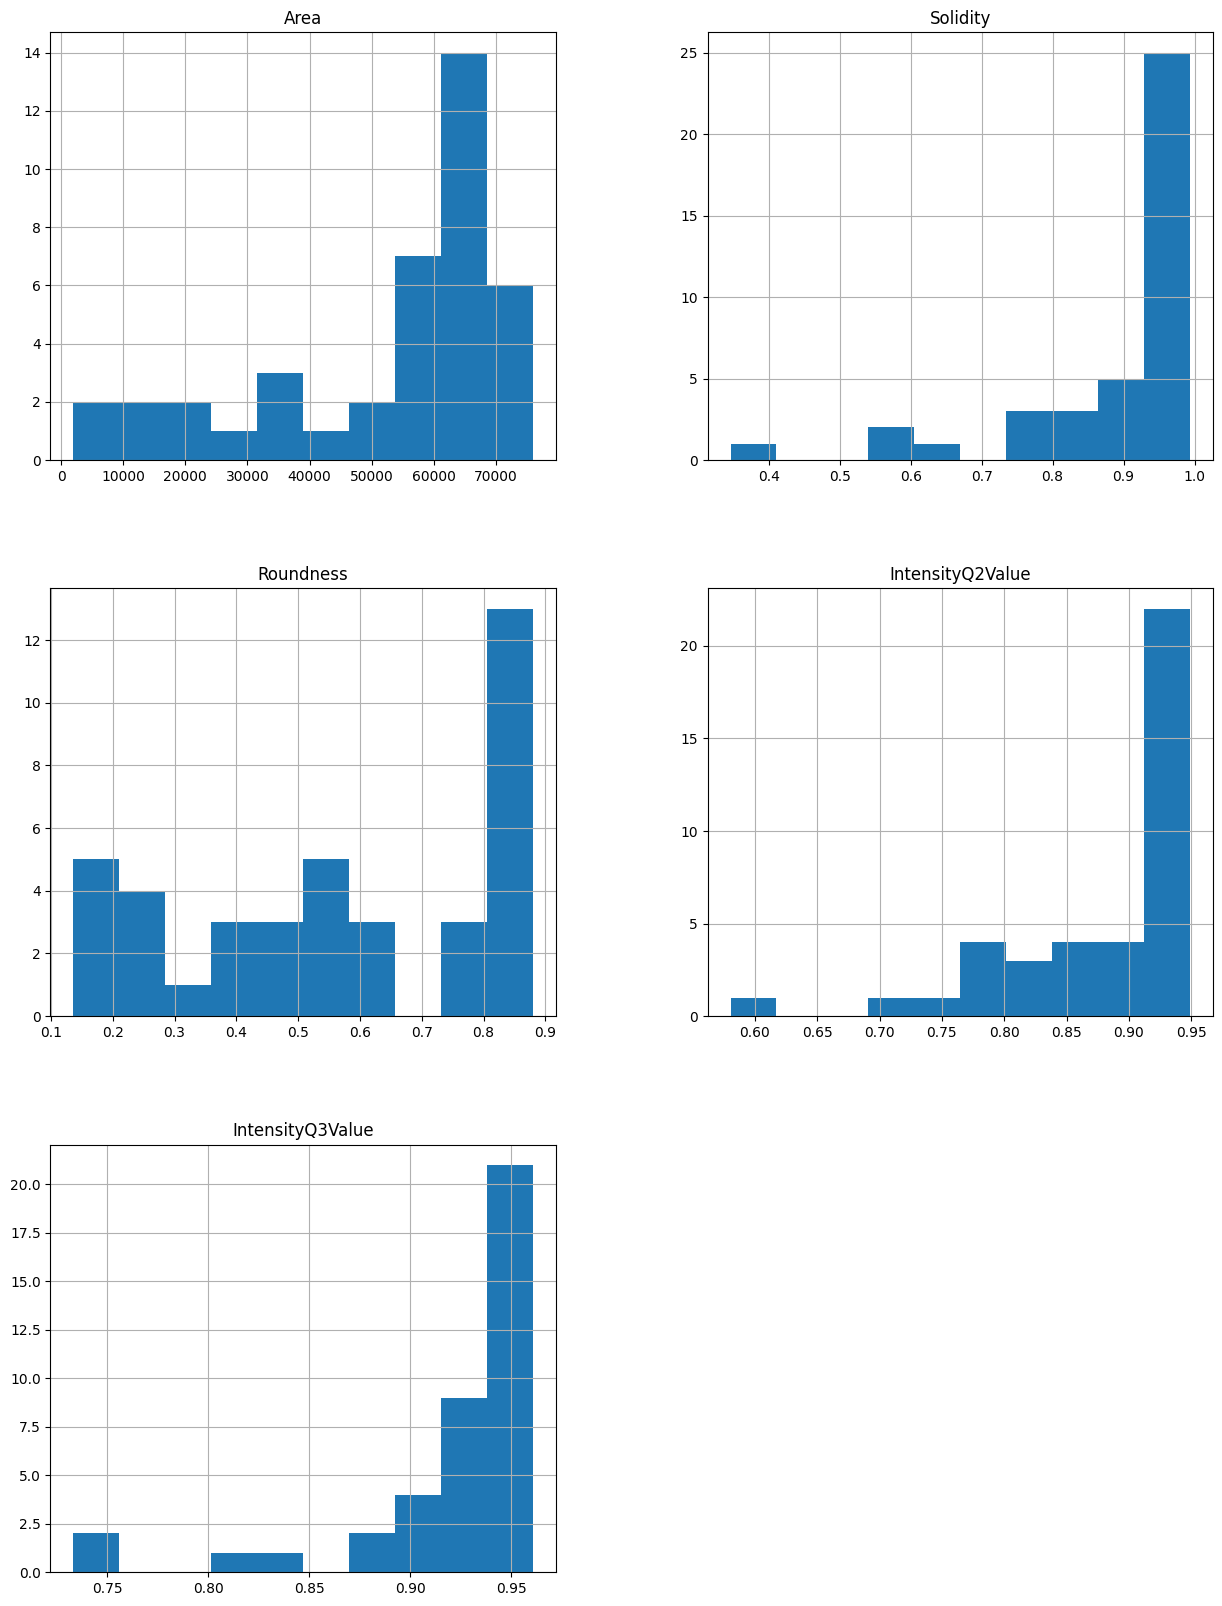

In [98]:
df.hist(figsize = (15,20))

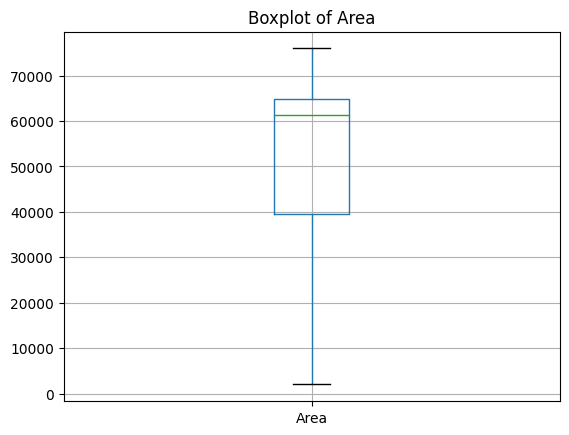

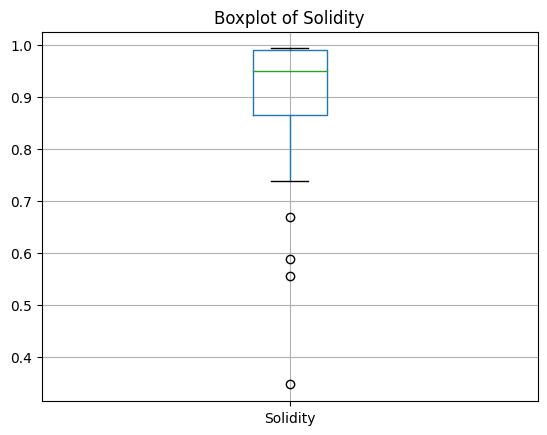

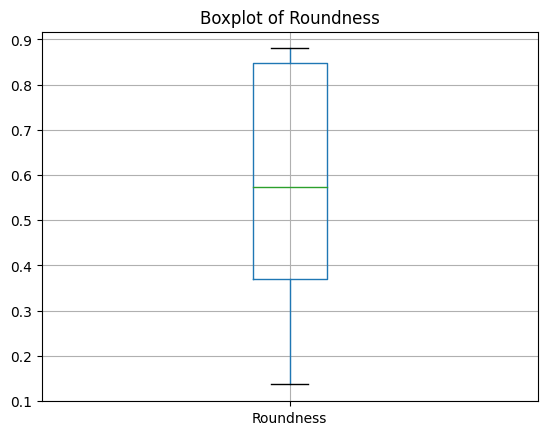

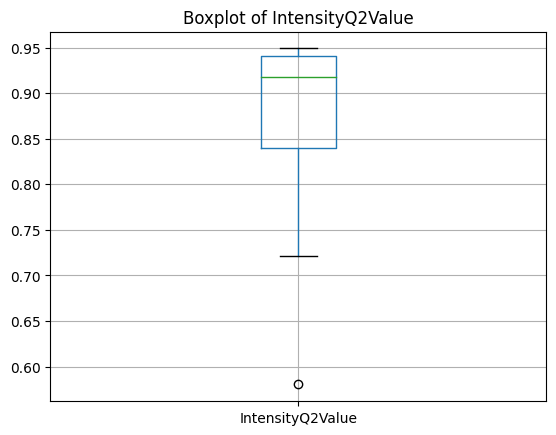

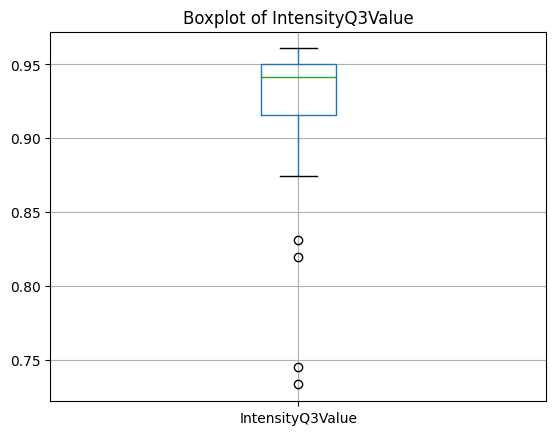

In [99]:
import matplotlib.pyplot as plt

for col in numerical_cols:
    plt.figure()
    df.boxplot(column=col, grid=True)
    plt.title(f"Boxplot of {col}")
    plt.show()

In [100]:
#Check the class balance
df['class'].value_counts()

class
fresh     20
rotten    20
Name: count, dtype: int64

## Data preprocessing

In [101]:
#Check null value
df.isnull().sum()

FileName            0
Area                0
Solidity            0
Roundness           0
IntensityQ2Value    0
IntensityQ3Value    0
class               0
dtype: int64

In [102]:
#Check duplicate value
df.duplicated().sum()

0

In [103]:
import pandas as pd
import numpy as np

def replace_outlier_to_null(df, col):
    """
    Replaces outlier values in a column with null values based on IQR thresholds.

    Args:
        df (pandas.DataFrame): The DataFrame containing the column to be analyzed.
        col (str): The name of the column to be analyzed for outliers.

    Returns:
        pandas.DataFrame: The DataFrame with outliers in the specified column replaced with null values.
    """

    # Calculate IQR
    percentile_25 = df[col].quantile(0.25)
    percentile_75 = df[col].quantile(0.75)
    iqr = percentile_75 - percentile_25

    # Calculate upper and lower thresholds
    upper_limit = percentile_75 + 1.5 * iqr
    lower_limit = percentile_25 - 1.5 * iqr

    # Replace outliers with null values
    df.loc[df[col] > upper_limit, col] = np.NAN
    df.loc[df[col] < lower_limit, col] = np.NAN

    return df

In [104]:
for col in numerical_cols:
    replace_outlier_to_null(df,col)

df

FileName     Area  Solidity  Roundness  IntensityQ2Value  \
0    FreshOrange01  62488.0  0.991118   0.850276          0.945098   
1    FreshOrange02  52843.0  0.991277   0.855550          0.945098   
2    FreshOrange03  59994.0  0.991341   0.847802          0.949020   
3    FreshOrange04  69836.0  0.944419   0.411703          0.945098   
4    FreshOrange05  58365.0  0.900278   0.500120          0.925490   
5    FreshOrange06  64067.0  0.992149   0.860977          0.901961   
6    FreshOrange07  55094.0  0.993580   0.879968          0.917647   
7    FreshOrange08  58572.0  0.930556   0.594168          0.941176   
8    FreshOrange09  63372.0  0.935380   0.403992          0.945098   
9    FreshOrange10  63111.0  0.943434   0.581339          0.925490   
10   FreshOrange11  70899.0  0.981600   0.734980          0.941176   
11   FreshOrange12  53211.0  0.992946   0.875363          0.917647   
12   FreshOrange13  61639.0  0.983062   0.788711          0.925490   
13   FreshOrange14  68657.0  0.960802   0.604170          0.941176   
14   FreshOrange15  75968.0  0.943503   0.656366          0.937255   
15   FreshOrange16  56349.0  0.992409   0.858864          0.941176   
16   FreshOrange17  62119.0  0.990939   0.855909          0.945098   
17   FreshOrange18  56985.0  0.991906   0.866648          0.901961   
18   FreshOrange19  64765.0  0.922618   0.550406          0.945098   
19   FreshOrange20  61694.0  0.905573   0.513274          0.925490   
20  RottenOrange01  38355.0       NaN   0.230194          0.850980   
21  RottenOrange02  37160.0  0.737521   0.168445          0.870588   
22  RottenOrange03  67763.0  0.978951   0.560114          0.792157   
23  RottenOrange04  67830.0  0.984456   0.567088          0.784314   
24  RottenOrange05  63775.0  0.992298   0.873231          0.850980   
25  RottenOrange06  73749.0  0.987745   0.834228          0.831373   
26  RottenOrange07  67494.0  0.956439   0.493480               NaN   
27  RottenOrange08  18799.0  0.778491   0.225291          0.949020   
28  RottenOrange09  34756.0  0.837979   0.269092          0.913725   
29  RottenOrange10  39772.0  0.780256   0.173754          0.756863   
30  RottenOrange11  69444.0  0.922231   0.231391          0.843137   
31  RottenOrange12  64907.0  0.992932   0.865093          0.901961   
32  RottenOrange13  61029.0  0.990795   0.803447          0.815686   
33  RottenOrange14  61763.0  0.990633   0.811448          0.764706   
34  RottenOrange15   2297.0       NaN   0.136413          0.917647   
35  RottenOrange16  29189.0  0.868927   0.339780          0.819608   
36  RottenOrange17   1991.0  0.855976   0.477101          0.890196   
37  RottenOrange18  14960.0       NaN   0.166370          0.784314   
38  RottenOrange19  20944.0  0.853186   0.380209          0.721569   
39  RottenOrange20  10275.0       NaN   0.170590          0.917647   

    IntensityQ3Value   class  
0           0.952941   fresh  
1           0.952941   fresh  
2           0.952941   fresh  
3           0.952941   fresh  
4           0.949020   fresh  
5           0.937255   fresh  
6           0.949020   fresh  
7           0.945098   fresh  
8           0.952941   fresh  
9           0.952941   fresh  
10          0.945098   fresh  
11          0.949020   fresh  
12          0.941176   fresh  
13          0.956863   fresh  
14          0.949020   fresh  
15          0.949020   fresh  
16          0.952941   fresh  
17          0.937255   fresh  
18          0.956863   fresh  
19          0.949020   fresh  
20          0.925490  rotten  
21          0.909804  rotten  
22          0.933333  rotten  
23          0.901961  rotten  
24          0.905882  rotten  
25          0.945098  rotten  
26               NaN  rotten  
27          0.960784  rotten  
28          0.933333  rotten  
29               NaN  rotten  
30          0.890196  rotten  
31          0.917647  rotten  
32          0.874510  rotten  
33          0.901961  rotten  
34          0.941176  rotten  
35          0.925490  r

In [105]:
#Refill null value with mean
for col in numerical_cols:
    df[col].fillna(value= df[col].mean(), inplace=True)

df

FileName     Area  Solidity  Roundness  IntensityQ2Value  \
0    FreshOrange01  62488.0  0.991118   0.850276          0.945098   
1    FreshOrange02  52843.0  0.991277   0.855550          0.945098   
2    FreshOrange03  59994.0  0.991341   0.847802          0.949020   
3    FreshOrange04  69836.0  0.944419   0.411703          0.945098   
4    FreshOrange05  58365.0  0.900278   0.500120          0.925490   
5    FreshOrange06  64067.0  0.992149   0.860977          0.901961   
6    FreshOrange07  55094.0  0.993580   0.879968          0.917647   
7    FreshOrange08  58572.0  0.930556   0.594168          0.941176   
8    FreshOrange09  63372.0  0.935380   0.403992          0.945098   
9    FreshOrange10  63111.0  0.943434   0.581339          0.925490   
10   FreshOrange11  70899.0  0.981600   0.734980          0.941176   
11   FreshOrange12  53211.0  0.992946   0.875363          0.917647   
12   FreshOrange13  61639.0  0.983062   0.788711          0.925490   
13   FreshOrange14  68657.0  0.960802   0.604170          0.941176   
14   FreshOrange15  75968.0  0.943503   0.656366          0.937255   
15   FreshOrange16  56349.0  0.992409   0.858864          0.941176   
16   FreshOrange17  62119.0  0.990939   0.855909          0.945098   
17   FreshOrange18  56985.0  0.991906   0.866648          0.901961   
18   FreshOrange19  64765.0  0.922618   0.550406          0.945098   
19   FreshOrange20  61694.0  0.905573   0.513274          0.925490   
20  RottenOrange01  38355.0  0.938547   0.230194          0.850980   
21  RottenOrange02  37160.0  0.737521   0.168445          0.870588   
22  RottenOrange03  67763.0  0.978951   0.560114          0.792157   
23  RottenOrange04  67830.0  0.984456   0.567088          0.784314   
24  RottenOrange05  63775.0  0.992298   0.873231          0.850980   
25  RottenOrange06  73749.0  0.987745   0.834228          0.831373   
26  RottenOrange07  67494.0  0.956439   0.493480          0.888185   
27  RottenOrange08  18799.0  0.778491   0.225291          0.949020   
28  RottenOrange09  34756.0  0.837979   0.269092          0.913725   
29  RottenOrange10  39772.0  0.780256   0.173754          0.756863   
30  RottenOrange11  69444.0  0.922231   0.231391          0.843137   
31  RottenOrange12  64907.0  0.992932   0.865093          0.901961   
32  RottenOrange13  61029.0  0.990795   0.803447          0.815686   
33  RottenOrange14  61763.0  0.990633   0.811448          0.764706   
34  RottenOrange15   2297.0  0.938547   0.136413          0.917647   
35  RottenOrange16  29189.0  0.868927   0.339780          0.819608   
36  RottenOrange17   1991.0  0.855976   0.477101          0.890196   
37  RottenOrange18  14960.0  0.938547   0.166370          0.784314   
38  RottenOrange19  20944.0  0.853186   0.380209          0.721569   
39  RottenOrange20  10275.0  0.938547   0.170590          0.917647   

    IntensityQ3Value   class  
0           0.952941   fresh  
1           0.952941   fresh  
2           0.952941   fresh  
3           0.952941   fresh  
4           0.949020   fresh  
5           0.937255   fresh  
6           0.949020   fresh  
7           0.945098   fresh  
8           0.952941   fresh  
9           0.952941   fresh  
10          0.945098   fresh  
11          0.949020   fresh  
12          0.941176   fresh  
13          0.956863   fresh  
14          0.949020   fresh  
15          0.949020   fresh  
16          0.952941   fresh  
17          0.937255   fresh  
18          0.956863   fresh  
19          0.949020   fresh  
20          0.925490  rotten  
21          0.909804  rotten  
22          0.933333  rotten  
23          0.901961  rotten  
24          0.905882  rotten  
25          0.945098  rotten  
26          0.936057  rotten  
27          0.960784  rotten  
28          0.933333  rotten  
29          0.936057  rotten  
30          0.890196  rotten  
31          0.917647  rotten  
32          0.874510  rotten  
33          0.901961  rotten  
34          0.941176  rotten  
35          0.925490  r

## Feature Engineering

In [106]:
#Feature selection
#Drop "FileName" column
df.drop("FileName", axis=1, inplace=True)

print(df)

       Area  Solidity  Roundness  IntensityQ2Value  IntensityQ3Value   class
0   62488.0  0.991118   0.850276          0.945098          0.952941   fresh
1   52843.0  0.991277   0.855550          0.945098          0.952941   fresh
2   59994.0  0.991341   0.847802          0.949020          0.952941   fresh
3   69836.0  0.944419   0.411703          0.945098          0.952941   fresh
4   58365.0  0.900278   0.500120          0.925490          0.949020   fresh
5   64067.0  0.992149   0.860977          0.901961          0.937255   fresh
6   55094.0  0.993580   0.879968          0.917647          0.949020   fresh
7   58572.0  0.930556   0.594168          0.941176          0.945098   fresh
8   63372.0  0.935380   0.403992          0.945098          0.952941   fresh
9   63111.0  0.943434   0.581339          0.925490          0.952941   fresh
10  70899.0  0.981600   0.734980          0.941176          0.945098   fresh
11  53211.0  0.992946   0.875363          0.917647          0.949020   fresh

In [107]:
#Feature transformation
from sklearn import preprocessing
#Define label encoder
label_encoder = preprocessing.LabelEncoder()

#Change dtype of 'class' to string
df['class'] = df['class'].astype(str)

#Using label encoder for categorical features
df['class'] = label_encoder.fit_transform(df['class'])

#print
print(df)

       Area  Solidity  Roundness  IntensityQ2Value  IntensityQ3Value  class
0   62488.0  0.991118   0.850276          0.945098          0.952941      0
1   52843.0  0.991277   0.855550          0.945098          0.952941      0
2   59994.0  0.991341   0.847802          0.949020          0.952941      0
3   69836.0  0.944419   0.411703          0.945098          0.952941      0
4   58365.0  0.900278   0.500120          0.925490          0.949020      0
5   64067.0  0.992149   0.860977          0.901961          0.937255      0
6   55094.0  0.993580   0.879968          0.917647          0.949020      0
7   58572.0  0.930556   0.594168          0.941176          0.945098      0
8   63372.0  0.935380   0.403992          0.945098          0.952941      0
9   63111.0  0.943434   0.581339          0.925490          0.952941      0
10  70899.0  0.981600   0.734980          0.941176          0.945098      0
11  53211.0  0.992946   0.875363          0.917647          0.949020      0
12  61639.0 

<Axes: >

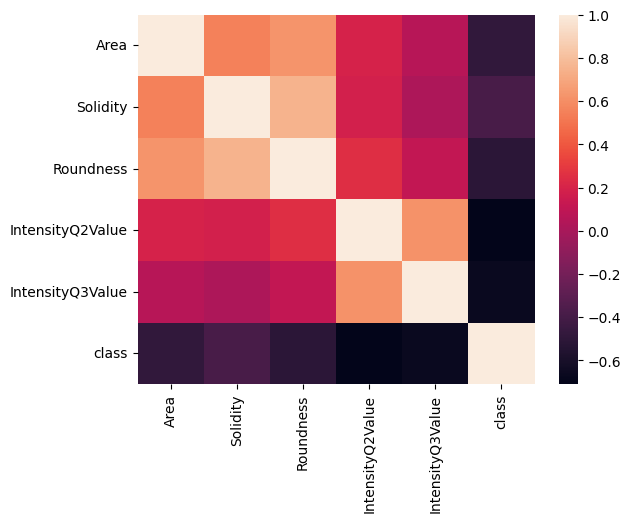

In [110]:
import seaborn as sns

sns.heatmap(df.corr())

In [113]:
def prepare_X_y(df):
    """
    Feature engineering and create X and y
    :param df: pandas dataframe
    :return: (X, y) output feature matrix (dataframe), target (series)
    """
    # Todo: Split data into X and y (using sklearn train_test_split). Return two dataframes

    #Get columns name to a list
    columns = df.columns.tolist()

    #Feature selection (Remove if necessary)

    columns.remove('class')


    X = df[columns].values
    y = df['class']
    return X, y

#Apply function
X, y = prepare_X_y(df)

##Train-test split

In [150]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 1
TRAIN_SIZE = 0.7

trainX, testX ,trainY, testY = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

## Modeling

In [151]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def build_model(X, y):
    # Define a Standard Scaler to normalize inputs
    scaler = MinMaxScaler()

    # set the tolerance to a large value to make the example faster
    gau_nb = GaussianNB()
    pipe = Pipeline(steps=[("scaler", scaler), ("gau_nb", gau_nb)]) #Build a pipeline with a scaler and a model

    # Parameters of pipelines can be set using '__' separated parameter names:
    var_smoothing_values = np.logspace(-4, -9, num=100)
    param_grid = {
        "scaler__feature_range": [(-1, 1), (0, 1)],
        'gau_nb__var_smoothing': var_smoothing_values
        }

    search = GridSearchCV(pipe, param_grid, n_jobs=2)
    search.fit(X, y)

    return search

In [158]:
from sklearn import metrics
from sklearn.metrics import classification_report

def calculate_performance(y_true, y_pred):
    """

    :param y_true: ground truth values
    :param y_pred: predictions
    :return:
    """
    # Todo: return your error value like accuracy, f1score, ...
    print("precision", metrics.precision_score(y_true, y_pred))
    print("recall", metrics.recall_score(y_true, y_pred))
    print("accuracy", metrics.accuracy_score(y_true, y_pred))
    print("F1",metrics.f1_score(y_true, y_pred) )
    print(classification_report(testY, y_pred))



In [159]:
#Build
naive_model = build_model(X, y)

#Apply model to predict
y_pred = naive_model.predict(testX)

In [160]:
calculate_performance(testY,y_pred)

precision 1.0
recall 1.0
accuracy 1.0
F1 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         8

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

